In [1]:
#imports 
import skimage
from skimage.io import imread, imshow, imsave, imread_collection, concatenate_images
from skimage.transform import resize
from skimage import img_as_ubyte
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

#from tqdm import tqdm

#get file names
import os
from copy import deepcopy
import shutil

#calculate mode
from scipy import stats

import numpy as np
import cv2

import json

%matplotlib inline



# <font color='blue'/> DataSet Exploration Toolkit

## Different dataset formats:

YOLO: <object-class> <x_center> <y_center> <width> <height>
BrainWash: (xmin, ymin, xmax, ymax)

## methods

In [11]:
def convert__xmin_ymin_xmax_ymax__2__class_xcent_ycent_width_height(box, imageW, imageH):
    xmin = (float(box[0])) / imageW
    ymin = (float(box[1])) / imageH
    xmax = (float(box[2])) / imageW
    ymax = (float(box[3])) / imageH
    
    h = (ymax - ymin)
    w = (xmax - xmin)
    xcent = xmin + w/2
    ycent = ymin + h/2

    # add 0 for class head
    return (0, xcent, ycent, w, h)

In [12]:
def convert__class_xmin_ymin_w_h__2__xcent_ycent_width_height(box):
    classN = int(box[0])
    xmin = float(box[1])
    ymin = float(box[2])
    w = float(box[3])
    h = float(box[4])
    
    xcent = xmin + w/2
    ycent = ymin + h/2
    
    return (classN, xcent, ycent, w, h)

In [13]:
def parseBrainWashLabelString(stringsList, imageW, imageH):
    outList = []
    
    split2 = stringsList[1][1:-2].split("),")
    for i in range(len(split2)):
        split2[i] = split2[i].replace("(", '')
        split2[i] = split2[i].replace(")", '')
        split2[i] = split2[i].replace(' ', '')
        
        outList.append(split2[i].split(','))
        #use below to convert to yolo. Use above to keep original format
#         outList.append(
#             convert__xmin_ymin_xmax_ymax__2__class_xcent_ycent_width_height(
#                 split2[i].split(','), imageW, imageH
#             )
#         )
        
    return outList

In [14]:
def processIDL_file(filePath, headLabelsDict):
    idlFile = open(filePath, 'r')
    fileLines = idlFile.readlines()
    
    for fileLine in fileLines:
        split1 = fileLine.split(":")
        imageName = split1[0][:-1].split("/")[-1]
        split2 = imageName.split('_')[1].split('.')[0].split('x')
        imgWidth = int(split2[0])
        imgHeight = int(split2[1])
        
        saveImageName = imageName.replace(".png",".jpg")
        saveImageName = saveImageName.replace('\"','')
        saveImageName = saveImageName.replace(';','')
        
        if not(imgWidth == 640 and imgHeight == 480):
            print("\n***different image size obsereved****\n")
        
        if len(split1) > 1:
            headLabelsDict[saveImageName] = parseBrainWashLabelString(split1, imgWidth, imgHeight)
        else:
            headLabelsDict[saveImageName] = []

In [15]:
def processBordPredFile__xmin_ymin_w_h(imageId, boardPredsPath):
    labelsList = []
    
    resFile = open(boardPredsPath + imageId.replace('.jpg', '.txt'), 'r')
    resLines =resFile.readlines()
    
    for line in resLines: 
        line = line.replace("\n", '')
        split1 = line.split(' ')
        labelsList.append(convert__class_xmin_ymin_w_h__2__xcent_ycent_width_height(split1))
            
    return labelsList

In [21]:
def writeLabelFile__class_xcent_ycent_width_height(imageId, outputLabelsPath, labelsList):
    outFile = open(outputLabelsPath + imageId.replace('.jpg', '.txt'), 'w')
    
    for label in labelsList:
        strL = str(label[0]) + ' ' + str(label[1]) + ' ' + str(label[2]) + ' ' +\
        str(label[3]) + ' ' + str(label[4]) + '\n' 
        outFile.write(strL)
    
    outFile.close()

In [22]:
def visualizeLabelLine(labelList, img):
    xcent = float(labelList[1]) * img.shape[1]
    ycent = float(labelList[2]) * img.shape[0]
    w = float(labelList[3]) * img.shape[1]
    h = float(labelList[4]) * img.shape[0]
    
    xmin = int(xcent - w/2)
    ymin = int(ycent - h/2)
    xmax = int(xcent + w/2)
    ymax = int(ycent + h/2)
    cv2.rectangle(img,(xmin, ymin),(xmax, ymax),(255,0,0),1)

In [23]:
def visualizePredLine(labelList, img):
    xcent = float(labelList[2]) * img.shape[1]
    ycent = float(labelList[3]) * img.shape[0]
    w = float(labelList[4]) * img.shape[1]
    h = float(labelList[5]) * img.shape[0]
    
    xmin = int(xcent - w/2)
    ymin = int(ycent - h/2)
    xmax = int(xcent + w/2)
    ymax = int(ycent + h/2)
    cv2.rectangle(img,(xmin, ymin),(xmax, ymax),(255,0,0),1)

## pipeline (using above methods)

In [ ]:
# Visualizing BrainWash Original  xmin_ymin_xmax_ymax
headLabelsDict = {}
processIDL_file('/home/hooman/brainwash_headDetection_dataset/brainwash/brainwash_test.idl',
                headLabelsDict)
processIDL_file('/home/hooman/brainwash_headDetection_dataset/brainwash/brainwash_val.idl',
                headLabelsDict)
processIDL_file('/home/hooman/brainwash_headDetection_dataset/brainwash/brainwash_train.idl',
                headLabelsDict)

imagesPath = "/home/hooman/brainwash_headDetection_dataset/brainwash/11_13_2014/brainwash_11_13_2014_images_hsJPG/"
visPath = "/home/hooman/brainwash_headDetection_dataset/brainwash/trainSetVis_11_13_2014/"

for imgId in os.listdir(imagesPath):
    print(imgId)
    img = imread(imagesPath + imgId)

    labels = headLabelsDict[imgId]
    for label in labels:
        xmin = int(float(label[0]))
        ymin = int(float(label[1]))
        xmax = int(float(label[2]))
        ymax = int(float(label[3]))

        cv2.rectangle(img,(xmin, ymin),(xmax, ymax),(255,0,0),3)

    imsave(visPath + imgId, img)
#     plt.imshow(img)
#     plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
#     plt.show()

In [42]:
# converting brain wash original and board preds to YOLO
imagesPath = "/home/hooman/brainwash_headDetection_dataset/brainwash/brainwash_10_27_2014_images_hsJPG/"
outputLabelsPath = "/home/hooman/brainwash_headDetection_dataset/brainwash/brainwash_10_27_2014_hsLabels_justHead/"
boardPredsPath = "/home/hooman/brainwash_headDetection_dataset/work_results_text/"

headLabelsDict = {}
processIDL_file('/home/hooman/brainwash_headDetection_dataset/brainwash/brainwash_test.idl',
                headLabelsDict)
processIDL_file('/home/hooman/brainwash_headDetection_dataset/brainwash/brainwash_val.idl',
                headLabelsDict)
processIDL_file('/home/hooman/brainwash_headDetection_dataset/brainwash/brainwash_train.idl',
                headLabelsDict)

for imageId in os.listdir(imagesPath):
    predLabelsList = processBordPredFile__xmin_ymin_w_h(imageId, boardPredsPath)
    combinedList = headLabelsDict[imageId] + predLabelsList
    writeLabelFile__class_xcent_ycent_width_height(imageId, outputLabelsPath, combinedList)

In [36]:
# spliting test,valid,train for Brainwash
filePath = '/home/hooman/brainwash_headDetection_dataset/brainwash/brainwash_train.idl'
outFilePath = '/home/hooman/brainwash_headDetection_dataset/brainwash/official_trainSet2.txt'
path2Append = '/home/hooman/brainwash_headDetection_dataset/brainwash/'

outFile = open(outFilePath, 'w')

idlFile = open(filePath, 'r')
fileLines = idlFile.readlines()

headLabelsDict = {}
for fileLine in fileLines:
    split1 = fileLine.split(":")
    imageName = split1[0][:-1].split("/")[-1]
    finalImageName = imageName.replace(".png",".jpg")
    finalImageName = finalImageName.replace('\"','')
    finalImageName = finalImageName.replace(';','')
    
    imagePath = split1[0][:-1].split("/")[0]
    
    if "10_27_2014" in imagePath:
        savePath = path2Append + "10_27_2014_all/" +finalImageName
    elif "11_13_2014" in imagePath:
        savePath = path2Append + "11_13_2014_all/" +finalImageName
    elif "11_24_2014" in imagePath:
        savePath = path2Append + "11_24_2014_all/" +finalImageName
    else:
        print(imageName)
        print(imagePath)
        print("Error cannot decide what folder this belongs to.")
        break

    outStr = str(savePath) + '\n'
    outFile.write(outStr)
    #print(outStr)
    
outFile.close()
idlFile.close()

In [18]:
# visualizing the training or test set from txt files
path2TrainingSet = "/home/hooman/brainwash_headDetection_dataset/brainwash/official_valSet.txt"
path2Vis = "/home/hooman/brainwash_headDetection_dataset/brainwash/valSetVis/"

trains = open(path2TrainingSet, 'r')
fileLines = trains.readlines()

for fileLine in fileLines:
    imagePath = fileLine.replace("\n", '')
    img = imread(imagePath)
    
    labelFile = open(imagePath.replace(".jpg", ".txt"), 'r')
    labelLines = labelFile.readlines()
    for line in labelLines:
        visualizeLabelLine(line.split(" "), img)
    
    #print(path2Vis + imagePath.split("/")[-1])
    imsave(path2Vis + imagePath.split("/")[-1], img)

In [46]:
#vis labels on images from directory
pathIm = "/home/hooman/justHead_testSet_fromTensent/images/"
pathLabels = '/home/hooman/justHead_testSet_fromTensent/yoloLabels_40-40/'
path2Vis = '/home/hooman/justHead_testSet_fromTensent/vis_GT_40-40/'
for imId in os.listdir(pathIm):
    img = imread(pathIm + imId)
    
    try:
        labelFile = open(pathLabels + imId.replace(".jpg",".txt"), 'r')
    except:
        print("Error didnot find labels for image")
        print(imId)
#         shutil.copy(pathIm + imId, "/home/hooman/brainwash_headDetection_dataset/brainwash/"\
#                     "11_13_2014_imagesWithNoCombinedLabels/" +imId)
        break

    labelLines = labelFile.readlines()
    for line in labelLines:
        visualizeLabelLine(line.split(" "), img)

    #print(path2Vis + imagePath.split("/")[-1])
    try:
        imsave(path2Vis + imId, img)
    except:
        print("Error could not save image")
        print(imId)
    



In [ ]:
#vis preds on images from directory
pathIm = "/home/hooman/coco/hsTest100_images/"
for imId in os.listdir(pathIm):
    img = imread(pathIm + imId)
    
   
    labelFile = open(
        "/home/hooman/headAndTorso_detection/release/text_res_balTestSetHH_3Class/" + imId.replace(".jpg",".txt"), 'r')
    labelLines = labelFile.readlines()
    for line in labelLines:
        visualizePredLine(line.split(" "), img)

    #print(path2Vis + imagePath.split("/")[-1])
    imsave("/home/hooman/headAndTorso_detection/release/visFormahdi/" + imId, img)

In [25]:
# concat multiple label files
labelDir1 = "/home/hooman/AlphaPose/11_13_2014_torosLabels_all/"
labelDir2 = "/home/hooman/AlphaPose/11_13_2014_personLabels_all/"
labelDir3 = "/home/hooman/brainwash_headDetection_dataset/brainwash/brainwash_11_13_2014_hsLabels_justHead/"
filanLabelDir = "/home/hooman/brainwash_headDetection_dataset/brainwash/11_13_2014_combinedLabels_yoloAndPose/"

for textFileName in os.listdir(labelDir1):
    with open(filanLabelDir + textFileName, 'w') as outfile:
        with open(labelDir1 + textFileName) as infile:
            outfile.write(infile.read())
            
        with open(labelDir2 + textFileName) as infile:
            outfile.write(infile.read())
            
        with open(labelDir3 + textFileName) as infile:
            outfile.write(infile.read())

In [58]:
# concat hs and mahdi labels for hardhat1
labelDir1 = "/home/hooman/hardHat_dataset/labels_hs/"
labelDir2 = "/home/hooman/hardHat_dataset/labels_mahdi/"

filanLabelDir = "/home/hooman/hardHat_dataset/combined_labels/"

for textFileName in os.listdir(labelDir1):
    with open(filanLabelDir + textFileName, 'w') as outfile:
        
        lab1F = open(labelDir1 + textFileName, 'r')
        lab1Lines = lab1F.readlines()
        for ln in lab1Lines:
            newLine1 = ln[0] + ln[10:]
            outfile.write(newLine1)

            
        lab2F = open(labelDir2 + textFileName, 'r')
        lab2Lines = lab2F.readlines()
        for ln in lab2Lines:
            if ln[0] == "0":
                newLine = "2" + ln[1:]
            if ln[0] == "1" or ln[0] == "2":
                newLine = "1" + ln[1:]
                
            outfile.write(newLine)

In [75]:
# concat hs and mahdi labels for hardhat2
labelDir1 = "/home/hooman/hardHat_dataset/5class_labels/"
labelDir2 = "/home/hooman/hardHat_dataset/labels_mahdi/"

filanLabelDir = "/home/hooman/hardHat_dataset/combined_labels/"

for textFileName in os.listdir(labelDir1):
    with open(filanLabelDir + textFileName, 'w') as outfile:
        
        lab1F = open(labelDir1 + textFileName, 'r')
        lab1Lines = lab1F.readlines()
        for ln in lab1Lines:
            if ln[0] == "0" or ln[0] == "1" or ln[0] == "2" or ln[0] == "3" or ln[0] == "4":
                newLine1 = "0" + ln[1:]
            outfile.write(newLine1)

            
        lab2F = open(labelDir2 + textFileName, 'r')
        lab2Lines = lab2F.readlines()
        for ln in lab2Lines:
            if ln[0] == "0":
                newLine = "2" + ln[1:]
            if ln[0] == "1" or ln[0] == "2":
                newLine = "1" + ln[1:]
                
            outfile.write(newLine)

In [76]:
#creating labels for Mahdi
labelDir1 = "/home/hooman/hardHat_dataset/5class_labels/"
labelDir2 = "/home/hooman/hardHat_dataset/labels_mahdi/"

filanLabelDir = "/home/hooman/hardHat_dataset/labels4Mahdi/"

for textFileName in os.listdir(labelDir1):
    with open(filanLabelDir + textFileName, 'w') as outfile:
        
        lab1F = open(labelDir1 + textFileName, 'r')
        lab1Lines = lab1F.readlines()
        for ln in lab1Lines:
            if ln[0] == "1" or ln[0] == "2" or ln[0] == "3" or ln[0] == "0":
                newLine1 = "4" + ln[1:]
            if ln[0] == "4":
                newLine1 = "3" + ln[1:]
            outfile.write(newLine1)

            
        lab2F = open(labelDir2 + textFileName, 'r')
        lab2Lines = lab2F.readlines()
        for ln in lab2Lines:   
            outfile.write(ln)

In [ ]:
# pick random images
import random
path1 = "/home/hooman/work_uniform/hardHatFromMahdi/justPreds/"
path2 = "/home/hooman/work_uniform/hardHatFromMahdi/randomTestSet_200/"
nbOfItems2pick = 200

all_list = os.listdir(path1)
random.shuffle(all_list) #shuffle method

for i in range(nbOfItems2pick):
    shutil.copy(path1 + all_list[i], path2 + all_list[i])

In [8]:
# convert vest,noVest,hat,NoHat predsOrLabels to torso, head
labelDir1 = "/home/hooman/hardHat_dataset/randomTestSet_200_correctedLabels_vest/"
filanLabelDir = "/home/hooman/hardHat_dataset/randomTestSet_200_correctedLabels_hs/"

for textFileName in os.listdir(labelDir1):
    with open(filanLabelDir + textFileName, 'w') as outfile:
        
        lab1F = open(labelDir1 + textFileName, 'r')
        lab1Lines = lab1F.readlines()
        for ln in lab1Lines:
            if ln[0] == "0": #person
                newLine1 = "2" + ln[1:]
            
            if ln[0] == "1" or ln[0] == "2": #torso
                newLine1 = "1" + ln[1:]
            
            if ln[0] == "3" or ln[0] == "4": #head
                newLine1 = "0" + ln[1:]

            outfile.write(newLine1)

In [47]:
# make text file out of folder and shuffle
import random
outFile = open("/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther"\
               "/trainingSet_contrast0.2-0.8.txt", 'w')
locPath = "/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther"\
"/images_aug_contrast0.2-0.8/"
putInFilePath = "/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther"\
"/imagesAndLabels_contrast0.2-0.8/"

namesList = os.listdir(locPath)
random.shuffle(namesList) #shuffle method

for fileName in namesList:
    outStr = putInFilePath + fileName + '\n'
    outFile.write(outStr)

outFile.close()

In [51]:
# shuffle a textFile
import random
outFile = open("/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther"\
               "/trainingSet_all_shuffled1.txt", 'w')

inFile = open("/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther"\
               "/trainingSet_all.txt", 'r')

inLines = inFile.readlines()
random.shuffle(inLines) #shuffle method

outFile.writelines(inLines)
outFile.close()
inFile.close()

In [ ]:
# check how many of each class in the entire set

path = '/home/hooman/hardHat_dataset/temp_1000/'
countHat = 0
countNoHat = 0
countPersonFromHead = 0
countPerson = 0
for fileName in os.listdir(path):
    file = open(path + fileName, 'r')
    lines = file.readlines()

    for ln in lines:
        if ln[0] == "3":
            countNoHat +=1
        if ln[0] == "4":
            countHat +=1
            
        if ln[0] == "0":
            countPerson +=1
            
        if ln[0] == "3" or ln[0] == "4":
            countPersonFromHead+=1
            
print("noHatCount:   " + str(countNoHat))
print("hatCount:   " + str(countHat))
print("countPersonFromHead:   " + str(countPersonFromHead))      
print("countPerson:   " + str(countPerson))   

In [ ]:
# vest preds to just head
labelDir1 = "/home/hooman/darknet_alex/hsHeadDetector_try6_onHH_vestClasses_1000Images/preds_BW_ck1000_0.05/"
filanLabelDir = "/home/hooman/darknet_alex/hsHeadDetector_try6_onHH_vestClasses_1000Images/preds_BW_ck1000_0.05_justHead/"

for textFileName in os.listdir(labelDir1):
    if ".txt" in textFileName:
        with open(filanLabelDir + textFileName, 'w') as outfile:

            lab1F = open(labelDir1 + textFileName, 'r')
            lab1Lines = lab1F.readlines()
            for ln in lab1Lines:
                if ln[0] == "3" or ln[0] == "4": #head
                    newLine1 = "0" + ln[1:]

                outfile.write(newLine1)

In [47]:
# hs (head torso person) preds to just head
labelDir1 = "/home/hooman/justHead_testSet_fromTensent/predsText/"
filanLabelDir = "/home/hooman/justHead_testSet_fromTensent/predsText_justHead/"
for textFileName in os.listdir(labelDir1):
    if ".txt" in textFileName:
        with open(filanLabelDir + textFileName, 'w') as outfile:

            lab1F = open(labelDir1 + textFileName, 'r')
            lab1Lines = lab1F.readlines()
            for ln in lab1Lines:
                if ln[0] == "0": #head
                    newLine1 = ln
                    outfile.write(newLine1)

In [2]:
# convert preds to labels
labelDir1 = "/home/hooman/otherHardHat_dataset/Test/preds/"
filanLabelDir = "/home/hooman/otherHardHat_dataset/Test/labels/"

for textFileName in os.listdir(labelDir1):
    with open(filanLabelDir + textFileName, 'w') as outfile:
        
        lab1F = open(labelDir1 + textFileName, 'r')
        lab1Lines = lab1F.readlines()
        for ln in lab1Lines:
            spl = ln.split(' ')
            newLine1 = spl[0] + ' ' + spl[2] + ' ' + spl[3] + ' ' + spl[4] + ' ' + spl[5]
            outfile.write(newLine1)

In [ ]:
#remove labels less than 40*40
path2Labels = "/home/hooman/justHead_testSet_fromTensent/yoloLabels/"
filanLabelDir = "/home/hooman/justHead_testSet_fromTensent/yoloLabels_40-40/"

for textFileName in os.listdir(path2Labels):
    labelFile = open(path2Labels+ textFileName, 'r')
    labelLines = labelFile.readlines()
    
    with open(filanLabelDir + textFileName, 'w') as outfile:
        for line in labelLines:
            labelList = line.split(" ")
            xcent = float(labelList[1]) * img.shape[1]
            ycent = float(labelList[2]) * img.shape[0]
            w = float(labelList[3]) * img.shape[1]
            h = float(labelList[4]) * img.shape[0]

            if w > 40.0 and h > 40.0:
                outfile.write(line)
                
        labelFile.close()

In [44]:
#remove preds less than 40*40
path2Labels = "/home/hooman/headAndTorso_detection/release/text_res_balTestSetHH_3Class_justHead/"
filanLabelDir = "/home/hooman/headAndTorso_detection/release/text_res_balTestSetHH_3Class_justHead_above40x40/"

for textFileName in os.listdir(path2Labels):
    labelFile = open(path2Labels + textFileName, 'r')
    labelLines = labelFile.readlines()
    
    with open(filanLabelDir + textFileName, 'w') as outfile:
        for line in labelLines:
            labelList = line.split(" ")
            xcent = float(labelList[2]) * img.shape[1]
            ycent = float(labelList[3]) * img.shape[0]
            w = float(labelList[4]) * img.shape[1]
            h = float(labelList[5]) * img.shape[0]

            if w > 40.0 and h > 40.0:
                outfile.write(line)
                
        labelFile.close()

In [ ]:
# Convert tensent json labels(xmin, xmax, ymin, ymax) to yolo(xcent, ycent, w, h)

imagesPath = '/home/hooman/justHead_testSet_fromTensent/images/'
path2SaveLabels = '/home/hooman/justHead_testSet_fromTensent/yoloLabels/'
jsonFile = open('/home/hooman/justHead_testSet_fromTensent/gongdi_results.json')
data = json.load(jsonFile)

for item in data:
    imageName = item['name'].split('//')[-1]
    if '.jpeg' in imageName:
        imageName = imageName.replace('.jpeg', '.jpg')
    if '.png' in imageName:
        imageName = imageName.replace('.png', '.jpg')

    try:
        image = imread(imagesPath + imageName)
        imH, imW, _ = image.shape
    except:
        print('Error could not open image:')
        print(imageName) 
        print('\n')
        break
        
    with open(path2SaveLabels + imageName.replace(".jpg", ".txt"), 'w') as outfile:
        if item["labels"]:
            for lab in item["labels"]:
                classId = -1
                if lab["category"] == "nohelmet":
                    classId = 0
                elif lab["category"] == "helmet":
                    #classId = 1
                    classId = 0
                else:
                    print("ERROR unexpected category")
                    print(imageName)
                    print('\n')
                    break

                xmin = lab["box2d"]["x1"] / imW
                xmax = lab["box2d"]["x2"] / imW
                ymin = lab["box2d"]["y1"] / imH
                ymax = lab["box2d"]["y2"] / imH

                xcent = (xmax + xmin)/2
                ycent = (ymax + ymin)/2
                width = xmax - xmin
                height = ymax - ymin

                newLine = str(classId) + ' ' + str(xcent) + ' ' + str(ycent) +\
                ' ' + str(width) + ' ' + str(height) + '\n'
                outfile.write(newLine)
        else:
            print('imageWith no label')
            print(imageName)
            print('\n')

In [18]:
#find missing labels
imagesPath = "/home/hooman/justHead_testSet_fromTensent/head/gongdi_67603/images/"
labelsPath = "/home/hooman/justHead_testSet_fromTensent/head/gongdi_67603/yoloLabels/"
path2MvImagesWithNoLabels = '/home/hooman/justHead_testSet_fromTensent/head/gongdi_67603/temp/'

labelsDic = {}
for labelName in os.listdir(labelsPath):
    labelsDic[labelName.replace(".txt", ".jpg")] = 1
    
for imgName in os.listdir(imagesPath):
    if imgName not in labelsDic.keys():
        shutil.move(imagesPath + imgName, path2MvImagesWithNoLabels)

In [ ]:
# split images into 4 
imagesPath = '/home/hooman/justHead_testSet_fromTensent/images/'
splitImagesPath = '/home/hooman/justHead_testSet_fromTensent/imagesSplit_overlap55/'
overlap = 55#10
for imageName in os.listdir(imagesPath):
    image = imread(imagesPath + imageName)

    imH, imW, _ = image.shape
    hh = int(imH/2)
    hw = int(imW/2)

    imL1 = image[0:hh+overlap,0:hw+overlap,:]
    imL2 = image[hh:imH,0:hw+overlap,:]
    imR1 = image[0:hh+overlap,hw:imW,:]
    imR2 = image[hh:imH,hw:imW,:]

    imsave(splitImagesPath + 'imL1_' + imageName, imL1)
    imsave(splitImagesPath + 'imL2_' + imageName, imL2)
    imsave(splitImagesPath + 'imR1_' + imageName, imR1)
    imsave(splitImagesPath + 'imR2_' + imageName, imR2)

In [305]:
# stich the predictions on split images back together
imagesPath = '/home/hooman/justHead_testSet_fromTensent/images/'
splitPredsPath = '/home/hooman/justHead_testSet_fromTensent/predsText/'
stichedPresPath = '/home/hooman/justHead_testSet_fromTensent/predsText_stiched/'
overlap = 55#10

for imageName in os.listdir(imagesPath):
    image = imread(imagesPath + imageName)
    imH, imW, _ = image.shape
    hh = int(imH/2)
    hw = int(imW/2)

    with open(stichedPresPath + imageName.replace(".jpg",".txt"), 'w') as outfile:
        
        predFileL1 = open(splitPredsPath+ 'imL1_' + imageName.replace(".jpg",".txt"), 'r')
        labelLines = predFileL1.readlines()
        for line in labelLines:
            labelList = line.split(" ")
            
            predClass = labelList[0]
            predProb = labelList[1]
            xcent = float(labelList[2]) * (hw+overlap)
            ycent = float(labelList[3]) * (hh+overlap)
            w = float(labelList[4]) * (hw+overlap)
            h = float(labelList[5]) * (hh+overlap)

            new_xcent = xcent / imW
            new_ycent = ycent / imH
            new_w = w / imW
            new_h = h / imH
            
            outStr = str(predClass) + ' ' + str(predProb) + ' ' + str(new_xcent) +\
            ' ' + str(new_ycent) + ' ' + str(new_w) + ' ' + str(new_h) + '\n' 
            outfile.write(outStr)
            
        predFileL1.close()
        
    
    
        predFileL2 = open(splitPredsPath+ 'imL2_' + imageName.replace(".jpg",".txt"), 'r')
        labelLines = predFileL2.readlines()
        for line in labelLines:
            labelList = line.split(" ")
            
            predClass = labelList[0]
            predProb = labelList[1]
            xcent = float(labelList[2]) * (hw+overlap)
            ycent = float(labelList[3]) * (imH - hh)
            w = float(labelList[4]) * (hw+overlap)
            h = float(labelList[5]) * (imH - hh)

            new_xcent = xcent / imW
            new_ycent = (ycent + hh) / imH
            new_w = w / imW
            new_h = h / imH

            outStr = str(predClass) + ' ' + str(predProb) + ' ' + str(new_xcent) +\
            ' ' + str(new_ycent) + ' ' + str(new_w) + ' ' + str(new_h) + '\n' 
            outfile.write(outStr)
        
        predFileL2.close()
        
        
        
        
        predFileR1 = open(splitPredsPath+ 'imR1_' + imageName.replace(".jpg",".txt"), 'r')
        labelLines = predFileR1.readlines()
        for line in labelLines:
            labelList = line.split(" ")
            
            predClass = labelList[0]
            predProb = labelList[1]
            xcent = float(labelList[2]) * (imW - hw)
            ycent = float(labelList[3]) * (hh+overlap)
            w = float(labelList[4]) * (imW - hw)
            h = float(labelList[5]) * (hh+overlap)

            new_xcent = (xcent + hw) / imW
            new_ycent = ycent / imH
            new_w = w / imW
            new_h = h / imH
            
            outStr = str(predClass) + ' ' + str(predProb) + ' ' + str(new_xcent) +\
            ' ' + str(new_ycent) + ' ' + str(new_w) + ' ' + str(new_h) + '\n'  
            outfile.write(outStr)
        
        predFileR1.close()
        
        
        
        predFileR2 = open(splitPredsPath+ 'imR2_' + imageName.replace(".jpg",".txt"), 'r')
        labelLines = predFileR2.readlines()
        for line in labelLines:
            labelList = line.split(" ")
            
            predClass = labelList[0]
            predProb = labelList[1]
            xcent = float(labelList[2]) * (imW - hw)
            ycent = float(labelList[3]) * (imH - hh)
            w = float(labelList[4]) * (imW - hw)
            h = float(labelList[5]) * (imH - hh)

            new_xcent = (xcent + hw) / imW
            new_ycent = (ycent + hh) / imH
            new_w = w / imW
            new_h = h / imH
            
            outStr = str(predClass) + ' ' + str(predProb) + ' ' + str(new_xcent) +\
            ' ' + str(new_ycent) + ' ' + str(new_w) + ' ' + str(new_h) + '\n'  
            outfile.write(outStr)
        
        predFileR2.close()

# <font color='blue'/> Image Manipulation Toolkit

## Images: Copying, Moving, Deleting from different directoreis

In [ ]:
# deleting files that are not in one dir from another
fileToKeepDict = {}

for fileName in os.listdir('/home/hooman/Downloads/MOTIONMETRICS (2)/FM/preds/'):
    fileToKeepDict[fileName[:-3]+'gmp'] = 1


    
for fileName in os.listdir('/home/hooman/Downloads/MOTIONMETRICS (2)/FM/1947EFC0-16D8-1588-A042-3534DFB3FA0F/'):
    if fileName not in fileToKeepDict:
        print(fileName)
        os.remove('/home/hooman/Downloads/MOTIONMETRICS (2)/FM/1947EFC0-16D8-1588-A042-3534DFB3FA0F/' + fileName)

In [ ]:
# deleting images that cannot be opened (usaully after augmentation)
dirToDeleteFrom = '/home/hooman/dataPreparation/hsTrainingSetBucyrusAndPnH/unet/randomCroppedImages/'

for fileName in os.listdir(dirToDeleteFrom):
    try:
        img = imread(dirToDeleteFrom + fileName)
    except:
        os.remove(dirToDeleteFrom + fileName)
        os.remove('/home/hooman/dataPreparation/hsTrainingSetBucyrusAndPnH/unet/randomCroppedMasks/' + fileName)

In [3]:
# copying files from one dir to another

import shutil

for imgId in os.listdir('/media/hooman/1tb-ssd-hs3-linu/BucketTracking-Project/poseNet/hydraulic/data/dataCleanup_round1/goodLabels'):
    shutil.copy('/media/hooman/1tb-ssd-hs3-linu/BucketTracking-Project/poseNet/hydraulic/data/images/' + imgId, '/media/hooman/1tb-ssd-hs3-linu/BucketTracking-Project/poseNet/hydraulic/data/try1_only_dataCleanup_round1_goodImages/images')

In [ ]:
# Exclusing testSet images from trainingSet for BucketTracking
# copying files from one dir to another

dirWithListOfimages = "/media/hooman/hsSsdPartUbuntu/FM_PROJECT/FMDL_3.1/cable/boxDetector_V2_multiclass_Cable/try1/dataFor__boxDetector_V2_multiclass_cable__try1/goodMatInsides_forBBLabelingOfYolo/"

dir2RemoveFrom = "/media/hooman/hsSsdPartUbuntu/FM_PROJECT/dataPreparation/FMDL_3.1/cable/fmdl-cable-trainingData/images/"


import shutil

movedLabels = []

for imgId in os.listdir(dirWithListOfimages):
    
    movedLabels.append(imgId)

    imgName = imgId.replace('.jpg', '.xml')
    
    
    if os.path.isfile(dir2RemoveFrom + imgId):
    #if os.path.isfile(dir2RemoveFrom + imgName):
    
        #shutil.move(dir2RemoveFrom + imgName, '/media/hooman/1tb-ssd-hs3-linu/BucketTracking-Project/cable/validationsSet_hsPicked_labels')
        
        shutil.copy(dir2RemoveFrom + imgId, '/media/hooman/hsSsdPartUbuntu/FM_PROJECT/FMDL_3.1/cable/boxDetector_V2_multiclass_Cable/try1/dataFor__boxDetector_V2_multiclass_cable__try1/temp')
    
        #os.remove(dir2RemoveFrom + imgId)
        #os.remove(dir2RemoveFrom + imgName)
        print(dir2RemoveFrom + imgName)
        
    
print("")
print("Moved labels and deleted images for  " + str(len(movedLabels))  + "  examples\n")

In [2]:
# putting images in individual folders

path2images = '/home/hooman/imageQuality_andIdentification_datasets/fromProduction/Dyne_hotel/20191209_hanting_ch03_20191207090000/registration/regPhotosAlligned/'
path2rootFolderOutput = '/home/hooman/imageQuality_andIdentification_datasets/fromProduction/Dyne_hotel/20191209_hanting_ch03_20191207090000/registration/staticGallery/'

count = 1
for imgName in os.listdir(path2images):
    if '.jpg' in imgName or '.png' in imgName:
        dirName = path2rootFolderOutput + 'person' + str(count) 
        count += 1
        os.makedirs(dirName)
        shutil.copy(path2images + imgName, dirName + '/' + imgName)

## Images: resizing, converting formats and channels, correcting ids

In [ ]:
#Resize and downsample all images to (128, 160, 3)
resizedImagesPath = '/home/hooman/dataPreparation/hsTestSet/images0PaddedForUNet/'

for fileName in os.listdir(imagesPath):

    img = imread(imagesPath + fileName) 
    
    imgResized = cv2.resize(img, (640, 480)) 

    # you can downsample with numpy too. I use opencv to be consistant.    imgDs = img[::4, ::4, :]
    imgDs = cv2.resize(imgResized, (0,0), fx=0.25, fy=0.25) 

    imgPadded = cv2.copyMakeBorder(imgDs,4,4,0,0,cv2.BORDER_CONSTANT,value=(0,0,0))
    
    cv2.imwrite(resizedImagesPath + fileName, imgPadded)

In [ ]:
# converting single channel images to 3 channels
imagesPath = '/home/hooman/justHead_testSet_fromTensent/head/gongdi_67603/images/'

for imId in os.listdir(imagesPath):
    try:  
        img = imread(imagesPath + imId)
    except:
        print('couldnt open')
        print(imId)
        print('\n')
        
    if len(img.shape) < 3:
        print(imId)
        print(img.shape)
        print('\n')
        
        img3Chan = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
        cv2.imwrite('/home/hooman/justHead_testSet_fromTensent/head/gongdi_67603/conv/' + imId, img3Chan)

In [ ]:
# converting single channel images to 3 channels (LOOPING OVER MULTIPLE FOLDERS)

img_dest_dir = '/home/hooman/Desktop/i2lData_cropped/'



for mainDir in os.listdir(img_dest_dir):
    

    for imId in os.listdir(img_dest_dir + mainDir):

        img = imread(img_dest_dir + mainDir + '/' + imId)
        if len(img.shape) < 3:
            img3Chan = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

            cv2.imwrite(img_dest_dir + mainDir + '/' + imId, img3Chan)

        else:
            print(img.shape)


In [ ]:
# Converting jpg image to png, and removing the jpgs
img_dest_dir = '/home/hooman/dataPreparation/hsTrainingSetBucyrusAndPnH/allImages/'



from PIL import Image


imageFileNameDic = {}

for file in os.listdir(img_dest_dir):
    fileName = file.replace(".jpg", "")
    #fileName = file.replace(".png", "")
    if fileName in imageFileNameDic:
        imageFileNameDic[fileName] += 1
    else:
        imageFileNameDic[fileName] = 0

        
        
for name in imageFileNameDic.keys():
    print(name)
    im = Image.open(img_dest_dir + '/' + name + '.jpg')
    im.save(img_dest_dir + '/' + name + '.png')
    os.remove(img_dest_dir + '/' + name + '.jpg')

In [ ]:
# Converting png image to jpg
jpgSavePath = '/home/hooman/brainwash_headDetection_dataset/brainwash/brainwash_10_27_2014_images_hsJPG/'
pngLoadPath = "/home/hooman/brainwash_headDetection_dataset/brainwash/brainwash_10_27_2014_images/"


from PIL import Image

for name in os.listdir(pngLoadPath):
    print(name)
    im = Image.open(pngLoadPath + name)
    im.save(jpgSavePath + name.replace(".png",".jpg"))

In [ ]:
# Converting jpg image to png, and removing the jpgs (looping over multiple folders)

img_dest_dir = '/home/hooman/Desktop/i2lData_cropped/'



from PIL import Image


for mainDir in os.listdir(img_dest_dir):


    imageFileNameDic = {}

    for file in os.listdir(img_dest_dir + mainDir):
        
        fileName = file.replace(".jpg", "")
        #fileName = file.replace(".png", "")
        if fileName in imageFileNameDic:
            imageFileNameDic[fileName] += 1
        else:
            imageFileNameDic[fileName] = 0



    for name in imageFileNameDic.keys():
        print(name)
        im = Image.open(img_dest_dir + mainDir + '/' + name + '.jpg')
        im.save(img_dest_dir + mainDir + '/' + name + '.png')
        os.remove(img_dest_dir + mainDir + '/' + name + '.jpg')

In [ ]:
# compressing png images with jpeg

from PIL import Image

saveDir = '/home/hooman/FM_PROJECT/dataPreparation/fmdlTestData-optical-hydraulic/compressedJpeg80/'

for imId in os.listdir('/home/hooman/FM_PROJECT/dataPreparation/fmdlTestData-optical-hydraulic/Frame/'):
    img = Image.open('/home/hooman/FM_PROJECT/dataPreparation/fmdlTestData-optical-hydraulic/Frame/'+ imId)
    
    fileName = imId.replace(".png", "")
    
    img.save(saveDir + '/' + fileName + '.jpg', quality=80,optimize=True)

In [ ]:
#Correcting image Ids by content matching singleImage
#HSNOTE: this does not work with abs error must be squared.

pathToCorrectNames = '/home/hooman/dataPreparation/testingMahdisNetworkOnMyLatestTestSetForComparison/input-orig/'
pathToWrongNames   = '/home/hooman/dataPreparation/testingMahdisNetworkOnMyLatestTestSetForComparison/outputOfSaveH5/'
pathToWrongPreds = '/home/hooman/dataPreparation/testingMahdisNetworkOnMyLatestTestSetForComparison/ouputOfNetworkJustOutput/'


for srcId in os.listdir(pathToWrongNames):

    minScore = 100000000
    minId = ''
    
    for targId in os.listdir(pathToCorrectNames):
        srcIm = imread(pathToWrongNames + srcId)

        temp= imread(pathToCorrectNames + targId)
        targIm = cv2.resize(temp, (srcIm.shape[1], srcIm.shape[0])) 

        dif = np.square((srcIm - targIm))
        score = np.sum(dif)

        if score < minScore:
            minScore = score
            minId = targId
            

    print("src: " + srcId + "  matched with: " + minId)
    os.rename(pathToWrongNames + srcId, pathToWrongNames + minId)
    os.rename(pathToWrongPreds + srcId, pathToWrongPreds + minId)

In [ ]:
#Correcting image Ids by content matching allChannels


pathToCorrectNames = '/home/hooman/dataPreparation/testingMahdisNetworkOnMyLatestTestSetForComparison/input-orig/'
pathToWrongNames   = '/home/hooman/dataPreparation/testingMahdisNetworkOnMyLatestTestSetForComparison/outputOfSaveH5/'

pathToCorrectNamesIn = '/home/hooman/dataPreparation/testingMahdisNetworkOnMyLatestTestSetForComparison/ouputOfNetworkAllChannels/' 

namesDic = {}
for srcId in os.listdir(pathToWrongNames):

    minScore = 100000000
    minId = ''
    
    for targId in os.listdir(pathToCorrectNames):
        srcIm = imread(pathToWrongNames + srcId)

        temp= imread(pathToCorrectNames + targId)
        targIm = cv2.resize(temp, (srcIm.shape[1], srcIm.shape[0])) 

        dif = np.square((srcIm - targIm))
        score = np.sum(dif)

        if score < minScore:
            minScore = score
            minId = targId
            
    print(srcId + "___" + minId)
    namesDic[srcId] = minId




import glob

for srcId in namesDic.keys():

    #print("src: " + srcId + "  matched with: " + minId)
    
    nameAr = srcId.split('_')
    nameAr = nameAr[0:2]

    shortName = ""
    for i in range(len(nameAr)):
        shortName = shortName + nameAr[i] + '_'

    chanFiles = glob.glob1(pathToCorrectNamesIn, shortName + '*')
    
    for fil in chanFiles:
        chan = fil.split('_')[2]
        #print(chan)
        
        if chan[0:2] == "ch":
            newname = chan + "_" + namesDic[srcId]
            print("renamed CH: " + fil + " to: " + newname + "\n")
            os.rename(pathToCorrectNamesIn + fil, pathToCorrectNamesIn + newname)
        else:
            newname = namesDic[srcId]
            print("renamed: " + fil + " to: " + newname + "\n")
            os.rename(pathToCorrectNamesIn + fil, pathToCorrectNamesIn + namesDic[srcId])    

In [ ]:
# convert .JPEG to .JPG
path2Jpeg = '/home/hooman/justHead_testSet_fromTensent/head/gongdi_67603/jpeg/'
path2SaveJpg = '/home/hooman/justHead_testSet_fromTensent/head/gongdi_67603/conv/'

for imId in os.listdir(path2Jpeg):
    try:
        image = imread(path2Jpeg + imId)
        imsave(path2SaveJpg + imId.replace('.jpeg', '.jpg'), image)
    except:
        print(imId)

## Images: Displaying side by side

In [13]:
# Showing Images side-by-side

predsDir1 = '/home/hooman/brainwash_headDetection_dataset/brainwash/10_27_2014_combinedLabels_yoloAndPose_vis/'

predsDir2 = '/home/hooman/brainwash_headDetection_dataset/brainwash/10_27_2014_combinedLabels_justPose_vis/'

dirToSaveResults = '/home/hooman/brainwash_headDetection_dataset/brainwash/yoloAndPose_sidebySide/'

for imgId in os.listdir(predsDir1):  
    #if '.png' in imgId:
    if '.jpg' in imgId:
        pred1 = imread(predsDir1 + imgId)
        pred2 = imread(predsDir2 + imgId)

        try:


            combImg = np.zeros((pred1.shape[0],1400, 3), np.uint8)

            combImg[:, 0:pred1.shape[1], :] = pred1
            combImg[:, 700:pred2.shape[1]+700, :] = pred2

            '''
            combImg = np.zeros((pred1.shape[0],1400), np.uint8)

            combImg[:, 0:pred1.shape[1]] = pred1
            combImg[:, 700:pred2.shape[1]+700] = pred2
            '''



            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(combImg,'personFromYolo',(30,70), font, 2,(255,255,255), 2, 0)
            cv2.putText(combImg,'personFromPose',(730,70), font, 2,(255,255,255), 2, 0)


            #plt.imshow(combImg)
            #plt.show()
            #break

            cv2.imwrite(dirToSaveResults + imgId, combImg)
        except:
            print(imgId)



In [ ]:
# Showing Images side-by-side 3 images large
predsDir1 = '/home/hooman/justHead_testSet_fromTensent/examples/labels_above40-40/'
predsDir2 = '/home/hooman/justHead_testSet_fromTensent/examples/preds_all/'
predsDir3 = '/home/hooman/justHead_testSet_fromTensent/examples/preds_onlyAbove40-40/'

dirToSaveResults = '/home/hooman/justHead_testSet_fromTensent/examples/side/'

for imgId in os.listdir(predsDir1):

    pred1 = imread(predsDir1 + imgId)
    pred2 = imread(predsDir2 + imgId)
    pred3 = imread(predsDir3 + imgId)

    totalW = pred1.shape[1] + pred2.shape[1] + pred2.shape[1] + 20
    combImg = np.zeros((pred1.shape[0],totalW, 3), np.uint8)

    combImg[:, 0:pred1.shape[1], :] = pred1
    offset1 = pred1.shape[1] + 10
    combImg[:, offset1:pred2.shape[1]+offset1, :] = pred2
    offset2 = pred2.shape[1]+offset1 + 10
    combImg[:, offset2:pred3.shape[1]+offset2, :] = pred3
    
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    textloc1 = int(pred1.shape[1] / 2) - 30
    textloc2 = int((offset1 + pred2.shape[1]+offset1)/2)- 30
    textloc3 = int((offset2 + pred3.shape[1]+offset2)/2)- 30
    
    cv2.putText(combImg,'groundTruth',(textloc1,70), font, 2,(0,255,0), 2, 0)
    cv2.putText(combImg,'allPreds',(textloc2,70), font, 2,(0,255,0), 2, 0)
    cv2.putText(combImg,'predsAbove40-40',(textloc3,70), font, 2,(0,255,0), 2, 0)

    cv2.imwrite(dirToSaveResults + imgId, combImg)
    #cv2.imwrite(dirToSaveResults + imgId, combImg)
    imsave(dirToSaveResults + imgId, combImg)


In [ ]:
# Putting the optical flow and U-Net outputs sidebyside.  

#FMDL_2018.04.30_11.38.09.png

temp = imread('/home/hooman/dataPreparation/fmdlTestData-optical-hydraulic/Frame/' + 'FMDL_2018.04.30_11.38.09.png')

frame = cv2.cvtColor(temp, cv2.COLOR_GRAY2BGR) 

plt.imshow(frame)
plt.show()



of = imread('/home/hooman/dataPreparation/fmdlTestData-optical-hydraulic/OpticalFlowMagnitude/' + 'FMDL_2018.04.30_11.38.09.png')

plt.imshow(of)
plt.show()




no = imread('/home/hooman/dataPreparation/fmdlTestData-optical-hydraulic/NetOut/' + 'FMDL_2018.04.30_11.38.09.png')

plt.imshow(no)
plt.show()


temp2 = imread('/home/hooman/dataPreparation/fmdlTestData-optical-hydraulic/VES_finalOutput/fragmentation_results/all/' + 'FMDL_2018.04.30_11.38.09.png')

fo = cv2.cvtColor(temp2, cv2.COLOR_GRAY2BGR) 

plt.imshow(fo)
plt.show()


print(np.amax(of))


combImg = np.zeros((frame.shape[0],2800, 3), np.uint8)

combImg[:, 0:frame.shape[1], :] = frame
combImg[:, 700:frame.shape[1]+700, :] = cv2.resize(cv2.cvtColor(of, cv2.COLOR_GRAY2BGR), (frame.shape[1], frame.shape[0])) 
combImg[:, 1400:frame.shape[1]+1400, :] = cv2.resize(cv2.cvtColor(no, cv2.COLOR_GRAY2BGR), (frame.shape[1], frame.shape[0])) 
combImg[:, 2100:fo.shape[1]+2100, :] = fo


plt.imshow(combImg)
plt.show()
cv2.imwrite('/home/hooman/' + 'combined_FMDL_2018.04.30_11.38.09.png', combImg)

## Converting legecy fm/wm and fontend stuff to each other

In [ ]:
# converting .GMP to .FMDL
import os
import glob
import base64


parentInputPath = "/media/hooman/New Volume/FM_PROJECT_STORAGE/QC-Tests/Hydraulics/OyuTolgoi-CAT6060/good/in/"

outputPath = "/media/hooman/New Volume/FM_PROJECT_STORAGE/QC-Tests/Hydraulics/OyuTolgoi-CAT6060/good/out/"

#for dires in os.listdir(parentInputPath):
 #   inputPath = parentInputPath + '/' + dires + '/'
    
    #files = glob.glob(inputPath+'*.gmp')

for filename in os.listdir(parentInputPath):

    print(filename)

    f = open(parentInputPath + filename,'r')

    text = f.read()

    outFileName = text[text.find("filename")+11:text.find("data") -3]
    print(outFileName)

    if (text.find("FMDL") > 0) & (text.find("FMDL") < text.find("data")):

        img_txt = text[text.find("data")+7:-4];
        print(img_txt)

        with open(outputPath+outFileName,"wb") as ff:

            ff.write(base64.b64decode(img_txt))

In [ ]:
# YAML to WMDL

import glob
from base64 import decodestring
import base64


import zlib
import yaml
filename = "C:/Software/Dev/DLWM-20171026-105/resources/CNRL/SH1006/DLWM_reference.yaml"
with open(filename, 'r') as stream:
    yamlfile = yaml.load(stream)
    
stream = open(filename, 'r')

import cv2
fs_read = cv2.FileStorage("D:/temp/test.yml", cv2.FILE_STORAGE_READ)
import yaml
filename = "D:/temp/test.yml"
with open(filename, 'r') as stream:
    yamlfile = yaml.load(stream)

In [4]:
#WMDL to YAML
import glob
from base64 import decodestring
import base64

inputPath = "/media/hooman/New Volume/WM_PROJECT_STORAGE/logsFromCobrePanama/Shovel03/oldLog/logs/"
outputPath = "/media/hooman/New Volume/WM_PROJECT_STORAGE/logsFromCobrePanama/Shovel03/oldLog/yaml/"
files = glob.glob(inputPath+'*.wmdl')
import zlib  
import os
for filename in files:
    wmdl = open(filename,'rb').read()
    wmyaml = zlib.decompress(wmdl)
    with open(outputPath+os.path.basename(filename)[:-5]+".yaml","wb") as f:
        f.write(wmyaml)

In [ ]:
#WMDL GMP            
import glob
from base64 import decodestring
import base64

inputPath = "N:/randd/temp/WMDL_Logs/WMDL_CVE_S20/"
outputPath = "C:/Software/Dev/DLWM-20180201/resources/CV/SH20/input_2/"
files = glob.glob(inputPath+'*.gmp')
for filename in files:
    f = open(filename,'r')
    text = f.read()
    print(text[text.find("filename")+11:text.find("data")])
    if (text.find("WMDL") > 0) & (text.find("WMDL") < text.find("data")):
        img_txt = text[text.find("data")+7:-4];
        with open(outputPath+text[text.find("filename")+11:text.find(".wmdl")+5],"wb") as f:
            f.write(base64.b64decode(img_txt))

In [ ]:
# MTDL GMP
import glob
import base64

inputPath = "N:/temp/MTDL-Sishen/PH03_4100/"
outputPath = "N:/randd/MachineLearning/Temp/Sishen/PH03_4100/"
files = glob.glob(inputPath+'*.gmp')
for filename in files:
    f = open(filename,'r')
    text = f.read()
    if (text.find("MTDL-LEGACY") > 0) & (text.find("MTDL-LEGACY") < text.find("data")):
        img_txt = text[text.find("data")+7:-4];
        with open(outputPath+text[text.find("filename")+13:text.find(".jpg")+4],"wb") as f:
            f.write(base64.b64decode(img_txt))

In [ ]:
# hs saving YAML from FMDL
import zlib

logFile = '/media/hooman/New Volume/WM_PROJECT_STORAGE/logsFromCobrePanama/Shovel03/oldLog/logs/WMDL_2017.11.25_08.36.15.wmdl'


dl_log = open(logFile, 'rb').read()

print(dl_log)

#decompressed_log = zlib.decompress(dl_log)

#decompressed_log_corrected = decompressed_log.replace(b"\t",b"")

#decompressed_log = zlib.decompress(dl_log).decode("ascii")

In [ ]:
# hs Saving Frames from YAML (this works)
import os
import io
import base64
import yaml
import matplotlib.pyplot as plt
from PIL import Image as PilImage

path2Yamls = '/media/hooman/New Volume/WM_PROJECT_STORAGE/logsFromCobrePanama/Shovel03/oldLog/yaml/'
path2SaveFrames = '/media/hooman/New Volume/WM_PROJECT_STORAGE/logsFromCobrePanama/Shovel03/oldLog/out/'


for yaml_file_name in os.listdir(path2Yamls):
    if '.yaml' in yaml_file_name:
        print('opening file:')
        print(path2Yamls + yaml_file_name)

        # Read YAML file
        with open(path2Yamls + yaml_file_name, 'r') as stream:
            data_loaded = yaml.load(stream)

        #print(data_loaded['Frame'])

        img_byteArray =  base64.b64decode(data_loaded['Frame'])

        image = PilImage.open(io.BytesIO(img_byteArray)).convert("RGB")
        #image.save(path2SaveFrames + yaml_file_name.replace(".yaml", ".png"),"PNG")

        plt.imshow(image)
        plt.show()


In [22]:
# hs Saving Frames from YAML (This decompresses too but hasn't worked for me yet)
import os
import io
import zlib
import base64
from base64 import b64encode, b64decode
import yaml
from PIL import Image as PilImage

path2Yamls = '/media/hooman/New Volume/WM_PROJECT_STORAGE/logsFromCobrePanama/Shovel03/oldLog/yaml/'
path2SaveFrames = '/media/hooman/New Volume/WM_PROJECT_STORAGE/logsFromCobrePanama/Shovel03/oldLog/out/'


for yaml_file_name in os.listdir(path2Yamls):
    if '.yaml' in yaml_file_name:
        print('opening file:')
        print(path2Yamls + yaml_file_name)

        # Read YAML file
        with open(path2Yamls + yaml_file_name, 'r') as stream:
            data_loaded = yaml.safe_load(stream)

        #print(data_loaded['Frame'])

        json_data = b64decode(data_loaded)
        json_data = json.loads(zlib.decompress(json_data).decode("ascii"))

        img_byteArray =  base64.b64decode(json_data['Frame'])

        image = PilImage.open(io.BytesIO(img_byteArray)).convert("RGB")
        image.save(path2SaveFrames + yaml_file_name.replace(".yaml", ".png"),"PNG")

        #plt.imshow(image)
        #plt.show()


opening file:
/media/hooman/New Volume/WM_PROJECT_STORAGE/logsFromCobrePanama/Shovel03/oldLog/yaml/WMDL_2017.11.25_08.36.15.yaml


TypeError: argument should be a bytes-like object or ASCII string, not 'dict'

## Cleaning up CSVs with bounding boxes

In [ ]:
# shuffling a csv  (adds an empty line somewhere, and moves the header)

csvRows = readCsvRows('/media/hooman/hsSsdPartUbuntu/FM_PROJECT/FMDL_3.1/backhoe/boxDetector_V2_multiclass/try2-withCaseObject-newData/trainingSet.csv')



# shuffle the rows
from random import shuffle
shuffle(csvRows)




#write the shuffled rows to csv
csv_file = open('/media/hooman/hsSsdPartUbuntu/FM_PROJECT/FMDL_3.1/backhoe/boxDetector_V2_multiclass/try2-withCaseObject-newData/trainingSet_shuffled.csv', "w") 


# write rows
for row in csvRows:
    csv_file.write(row + '\n')

csv_file.close()

print("wrote " + str(len(csvRows)) + " rows to csv file\n")

In [ ]:
#read rows from the file you wanna append to
existingRowsDic = getCertainClassRowsDictFromCsv('/home/hooman/ssdMobileNet_multiClass_bucket_rockInside_FineInside_NoTeeth_NoCase/try5/trainSet_multiClass_bucket_fineRock_try5_manuallyCleaned.csv', ['matInside'])



#read rows from the file you wanna get the new rows from
rowsDicToAddFrom = getCertainClassRowsDictFromCsv('/home/hooman/ssdMobileNet_multiClass_bucket_rockInside_FineInside_NoTeeth_NoCase/unusedCsvFiles/trainSet_multiClass_bucket_fineRockInapp_try3_uncleaned.csv', ['matInside'])



#Append the missing rows
n = 0
rowsDicToAddTo = {}
for imId in os.listdir('/home/hooman/dataPreparation/hsTrainingSet/imsToAddMatInsideFor/'):
    n += 1
    print(imId)
    if imId not in existingRowsDic:
        if imId in rowsDicToAddFrom:
            rowsDicToAddTo[imId] = rowsDicToAddFrom[imId]
        else:
            print("error didn't find:  " + imId + "\n")
    else:
        print("already there\n")

print("processed " + str(n) + " rows")

writeRowDicToCsv(rowsDicToAddTo, '/home/hooman/ssdMobileNet_multiClass_bucket_rockInside_FineInside_NoTeeth_NoCase/try4/trainSet_multiClass_bucket_fineRock_try4_manuallyCleaned.csv')

In [ ]:
# delete images from csv
imIdsToDelete = os.listdir('/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/FMDL_3.1/cable/boxDetector_V2_multiclass_Cable/try1/dataFor__boxDetector_V2_multiclass_cable__try1/examplesToRemove/')

csvToWorkWith = '/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/FMDL_3.1/cable/boxDetector_V2_multiclass_Cable/try1/dataFor__boxDetector_V2_multiclass_cable__try1/firstTry_final.csv'


existingRows = readCsvRows(csvToWorkWith)

n1 = 0
for row in existingRows:
    vals = row.split(',')

    if vals[0] not in imIdsToDelete:
        existingRows.remove(row)
        n1 += 1
        
print("in the first run deleted " + str(n1) +' rows\n')

n2 = 0
for row in existingRows:
    vals = row.split(',')

    if vals[0] not in imIdsToDelete:
        existingRows.remove(row)
        n2 += 1
        
print("in the second run deleted " + str(n2) +' rows\n')
print("deleted " + str(n1+n2) + " rows in total")





# open the file
csv_file = open(csvToWorkWith, "w") 

# define column names
columnTitles = "filename,pathname,xmins,xmax,ymins,ymax,class\n"
csv_file.write(columnTitles)

# write rows
for r in existingRows:
    row = r + '\n'
    csv_file.write(row)

csv_file.close()

print("wrote " + str(len(existingRows)) + " rows to csv file\n")



In [ ]:
# add no bucket rows to existing csv and shuffle its rows

csvRows = readCsvRows('/home/hooman/ssdMobileNet_multiClass_bucket_rockInside_FineInside_NoTeeth_NoCase/try5/trainSet_multiClass_bucket_fineRock_try5_manuallyCleaned.csv')

#getRid of the empty row at the end
csvRows = csvRows[0:len(csvRows)-1]




# add the no bucket rows for the images in dir
for imId in os.listdir('/home/hooman/ssdMobileNet_multiClass_bucket_rockInside_FineInside_NoTeeth_NoCase/try6/noShovelImagesToAdd/'):
    newRow = str(str(imId) + ',' + str(imagesPath) + str(imId) + ',' + '' + ',' + '' + ',' + '' + ',' + '' + ',' + '')
    print(newRow)
    
    csvRows.append(newRow)
    

    
    
# shuffle the rows
from random import shuffle
shuffle(csvRows)




#write the shuffled rows to csv
csv_file = open('/home/hooman/ssdMobileNet_multiClass_bucket_rockInside_FineInside_NoTeeth_NoCase/try5/trainSet_multiClass_bucket_fineRock_try5_manuallyCleaned_new.csv', "w") 


# write rows
for row in csvRows:
    csv_file.write(row + '\n')

csv_file.close()

print("wrote " + str(len(csvRows)) + " rows to csv file\n")

In [ ]:
# remove matInsideBoundary rows from CSV

rowsDic = getCertainClassRowsDictFromCsv('/home/hooman/dataPreparation/hsTrainingSetBucyrusAndPnH/unet/trainSet_bucketAndMatInsideBoundaries_allImages_BucAndPnH_cleaned.csv', ['bucket'])

writeRowDicToCsv(rowsDic, '/home/hooman/dataPreparation/hsTrainingSetBucyrusAndPnH/unet/trainSet_justBucketBoundaries_allImages_BucAndPnH_cleaned.csv')

## Converting existing network CSVs to out csv format

The CSVs produced by the existing networks provide the topLeft cornor's x value, yvalu, a width, and a height. This must be converted to the format used by us which provides top left and bottom right cornors.

In [ ]:
existNetRows = readCsvRows("/home/hooman/resultsFromExistingNetwork/testSetFregmentationResults/output.csv")

In [ ]:
existNetRowsDict = {}
for row in existNetRows[0:60]:
    vals = row.split(',')
    existNetRowsDict[vals[0]] = vals[1:5]

In [ ]:
gt_rows = readCsvRows("/home/hooman/dataPreparation/testSet_noBbxImagesIncluded.csv")

In [ ]:
#write rows
rows = []
for row in gt_rows[1:len(gt_rows)-1]:
    vals = row.split(',')
    fileName = vals[0]
    filePath = imagesPath + fileName
    print("processing file:\n", filePath)
    
    if fileName in existNetRowsDict:
        topx, topy, width, height = existNetRowsDict[fileName]

        (topx, topy, width, height) = (int(round(float(topx))), int(round(float(topy))), int(round(float(width))), int(round(float(height)))) 

        xmin = topx
        xmax = topx + width
        ymin = topy
        ymax = topy + height
        
        row = fileName + "," + filePath + "," + str(xmin) +","+ str(xmax) + "," + str(ymin) + "," + str(ymax) + "," + "bucket" + "\n"
        
    else:
        row = fileName + "," + filePath + "," + "" +","+ "" + "," + "" + "," + "" + "," + "bucket" + "\n"
        print("Found no bucket boundary\n")
        
    rows.append(row)
    
print("processes "+ str(len(rows)) + " rows\n")

In [ ]:
writeRowsToCsv(rows, "/home/hooman/resultsFromExistingNetwork/testSetFregmentationResults/testSetOutputConverted.csv")

## Converting .pdn files to .png

In [ ]:
#converting .pdn (dot net) to pnd

import pypdn

pdnsDir = "/media/hooman/hsSsdPartUbuntu/FM_PROJECT/dataPreparation/FMDL_3.1/pdnLabels/"
finalDir = '/media/hooman/hsSsdPartUbuntu/FM_PROJECT/dataPreparation/FMDL_3.1/regen/'

#fileName = '1_20161115-222501_0001n0_16697.pdn'
for fileName in os.listdir(pdnsDir):

    #read the layer info
    layeredImage = pypdn.read(pdnsDir + fileName)
    #print(layeredImage)


    #make the background invisible
    layer = layeredImage.layers[0]
    layer.visible = False


    #Combine the layers into a numpy image
    flatImage = layeredImage.flatten(asByte=True)

    #plt.figure()
    #plt.imshow(flatImage)
    #plt.show()

    newFileName = fileName.replace('.pdn', '.png')
    cv2.imwrite(finalDir + newFileName, flatImage)

## working with h5 files

In [ ]:
#import skimage
#from skimage.io import imread, imshow, imread_collection, concatenate_images
#from skimage import img_as_ubyte
import matplotlib.pyplot as plt


import os
#from scipy import stats

import numpy as np
import cv2

import h5py

%matplotlib inline

In [ ]:
# Read an H5 file
filename = 'C:\\Users\\hooman\\Desktop\\WM2.0Project\\oldOutputOfH5maker\\60x150_Synt_False_Norm_True_Enhance_False_HistEqu_False_HistNorm_False\\Test.h5'
file = h5py.File(filename, 'r')

In [ ]:
#Reading and desplaying one image
imgnb = 30

for imgnb in range(23584):
    image10 = list(file['data'][imgnb])
    height10 = list(file['height'][imgnb])
    label10 = list(file['label'][imgnb])
    mask10 = list(file['mask'][imgnb])

    img = cv2.cvtColor(image10[0], cv2.COLOR_GRAY2BGR)

    print(len(img))
    print(len(img[0]))

    print(height10)
    print(label10)
    print(mask10)


    cv2.circle(img,(30, int((1-height10[0])*150)), 2, (0,255,0), -1)
    cv2.circle(img,(30, int((1-height10[1])*150)), 2, (0,0,255), -1)
    cv2.circle(img,(30, int((1-height10[2])*150)), 2, (255,0,0), -1)
    cv2.circle(img,(30, int((1-height10[3])*150)), 2, (255,255,0), -1)


    plt.imshow(img)
    plt.show()

In [ ]:
#Save an array of images into an h5 file
outputH5Path = "N:\\randd\\MachineLearning\\Projects\\ShovelMetrics\\Optical\\Dataset\\BucketPattern\\nLS_163_Backhoe\\WM_FM_TM_EMDUBUO_CACA\\h5\\Telfer_test_h5\\h5\\TestB.h5"
with h5py.File(outputH5Path, "w") as outputFile:
    images = outputFile.create_dataset('data', (108,1,222,254), dtype='f')    
    outputFile.flush()
    
    i = 0
    for fImg in imgPyAr:
        images[i, :, :, :]  = np.expand_dims(fImg[:,:, 0], axis=0)
        
        i+=1

In [ ]:
#Writing just 100 of images to h5 file

inputFile = h5py.File('C:\\Users\\hooman\\Desktop\\WM2.0Project\\h5MakerOutput_10-0\\60x150_Synt_False_Norm_True_Enhance_False_HistEqu_False_HistNorm_False\\Test.h5', 'r')

with h5py.File('C:\\Users\\hooman\\Desktop\\WM2.0Project\\oldOutputOfH5maker\\reduced.h5', "w") as outputFile:
    images = outputFile.create_dataset('data', (804828,1,150,60), dtype='f')
    heights = outputFile.create_dataset('height', (804828,4), dtype='f')
    labels = outputFile.create_dataset('label', (804828,4), dtype='f')
    masks = outputFile.create_dataset('mask', (804828,4), dtype='f')
    
    outputFile.flush()
    
    i = 0
    for imgnb in range(0,10000,50):
        images[i]  = inputFile['data'][imgnb]
        heights[i] = inputFile['height'][imgnb]
        labels[i]  = inputFile['label'][imgnb]
        masks[i]   = inputFile['mask'][imgnb]
        
        i+=1

<font color='red'>To combine multiple files into one use external links. h5 has the functionality that you can make external links to multiple files (no matter whre they are) inside one file. Your progrtams can then use that one file as if it has the entire data in it.

### Legacy U-Net padding

In [ ]:
# Identify top left and bottom right corners of an image with black margin


for i in range(222) :
    for j in range(254):
        flag = False
        if not img[i,j,:].all() == 0:
            print(i)
            print(j)
            flag = True
            break
    if flag:
        break
        
print("\n\n\n")        
for i in reversed(range(222)) :
    for j in reversed(range(254)):
        flag = False
        if not img[i,j,:].all() == 0:
            print(i)
            print(j)
            flag = True
            break
    if flag:
        break

In [ ]:
# resize and pad a directory of images for unet

input_dir = "N:\\randd\\MachineLearning\\Projects\\ShovelMetrics\\Optical\\Dataset\\BucketPattern\\nLS_163_Backhoe\\WM_FM_TM_EMDUBUO_CACA\\h5\\Telfer_test_h5\\image\\"
imgPyAr = []

for img_name in os.listdir(input_dir):
    img = cv2.imread(input_dir + img_name)
    #plt.imshow(img)
    #plt.show()

    orig_h, orig_w, _ = img.shape
    print('orig_h: ' + str(orig_h) + '\norig_w: ' + str(orig_w))



    resized_img = cv2.resize(img,(orig_w/4, orig_h/4))
    #plt.imshow(resized_img)
    #plt.show()

    resized_h, resized_w, _ = resized_img.shape
    print('resized_h: ' + str(resized_h) + '\nresized_w: ' + str(resized_w))


    final_h = 222
    final_w = 254
    margin_r = 49
    margin_b = 57
    final_img = np.zeros((final_h, final_w, 3),dtype = np.float32)
    print(final_img.shape)
    margin_l = final_w - margin_r - resized_w
    margin_t = final_h - margin_b - resized_h
    print('margin_l: ' + str(margin_l) + '\nmargin_t: ' + str(margin_t))


    final_img[margin_t:(final_h - margin_b), margin_l:(final_w - margin_r), :] = resized_img[:, :, :]/float(255)

    #plt.imshow(final_img)
    #plt.show()
    imgPyAr.append(final_img)

## Image Augmentation using imgaug

In [ ]:
# Get and resize train images and masks (same as in unet notebook except just one image)
TRAIN_PATH = '/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/FMDL_3.1/UNet_Hydraulics/hsUnet_try0_sameNetworkAs_try21_1chan_roiDelineatorVersion-1/dataFor__hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/finalTrainingSet_images_fullSize/'

MASK_PATH  = '/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/FMDL_3.1/UNet_Hydraulics/hsUnet_try0_sameNetworkAs_try21_1chan_roiDelineatorVersion-1/dataFor__hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/finalTrainingSet_masks_fullSize/'

from skimage import io

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

train_ids = os.listdir(TRAIN_PATH)
train_ids = train_ids[4:6]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

for n, fileName in tqdm(enumerate(train_ids), total=len(train_ids)):
    img = imread(TRAIN_PATH + fileName)[:,:,:IMG_CHANNELS]
    
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    mask_ = imread(MASK_PATH + fileName )

    #expand dim just converts the (h,w,) image to (h,w,1) look at above for experimentation with np.expand_dim
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                  preserve_range=True), axis=-1)

    #hs this in effect adds all the masks together into one mask of the same size.Since masks are bindary.
    mask = np.maximum(mask, mask_)
    Y_train[n] = mask

In [ ]:
# Check if the data we just loaded looks all right
ix = 0
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

## Generatign FM-FrameSelection Plots

In [ ]:
#Generatign FM-FrameSelection Plots

allFramesDir = '/media/hooman/1tb-ssd-hs3-linu/BucketTracking-Project/hydraulic/frameSelection/try7_t40b10_0,150,200,125,1,outSideImageObjRemoved/allFrames_1004_ESP_S04_017/'

bufferedFramesDir = '/media/hooman/1tb-ssd-hs3-linu/BucketTracking-Project/hydraulic/frameSelection/try7_t40b10_0,150,200,125,1,outSideImageObjRemoved/bufferedFrames_1004_ESP_S04_017/'

selectedFramesDir = '/media/hooman/1tb-ssd-hs3-linu/BucketTracking-Project/hydraulic/frameSelection/try7_t40b10_0,150,200,125,1,outSideImageObjRemoved/selectedFrames_1004_ESP_S04_017/'

vidName = '1004_ESP_S04_017_fmSelection.png'

savePath = '/media/hooman/1tb-ssd-hs3-linu/BucketTracking-Project/hydraulic/frameSelection/try7_t40b10_0,150,200,125,1,outSideImageObjRemoved/'

allFrames = []
for imName in os.listdir(allFramesDir):
    allFrames.append(int(imName.split('_')[-1][:-4]))
    
allFrames.sort()



bufferedFrames = []
for imName in os.listdir(bufferedFramesDir):
    bufferedFrames.append(int(imName.split('_')[-1][:-4]))
    
bufferedFrames.sort()




selectedFrames = []
for imName in os.listdir(selectedFramesDir):
    selectedFrames.append(int(imName.split('_')[-1][:-4]))
    
selectedFrames.sort()


plt.figure(figsize=(30,5))
ax = plt.axes()
loc = plticker.MultipleLocator(base=1800.0)
ax.xaxis.set_major_locator(loc)
ax.grid()

plt.plot(allFrames, len(allFrames) * [0], label='received')
plt.plot(bufferedFrames, len(bufferedFrames) * [0.2], 'bo', label='buffered')
plt.plot(selectedFrames, len(selectedFrames) * [0.5], 'go', label='selected')
plt.ylabel('buffered=Blue,  Selected=Green')
plt.xlabel('frameNumber(1 minute tick)')


plt.savefig(savePath + vidName)
plt.legend('best')
    
plt.show()


hsDic = {'received': len(allFrames), 'buffered':len(bufferedFrames), 'selected':len(selectedFrames)}
plt.bar(hsDic.keys(), hsDic.values(), color='g')

plt.show()

In [ ]:
# library's example of mask augmentation

import imgaug as ia
from imgaug import augmenters as iaa
import imageio
import numpy as np

ia.seed(1)


image = X_train[0]
segmap = Y_train[0]
segmap = ia.SegmentationMapOnImage(segmap, shape=image.shape, nb_classes=1+1)

# Define our augmentation pipeline.
seq = iaa.Sequential([
    iaa.Dropout([0.05, 0.2]),      # drop 5% or 20% of all pixels
    iaa.Sharpen((0.0, 1.0)),       # sharpen the image
    iaa.Affine(rotate=(-45, 45)),  # rotate by -45 to 45 degrees (affects heatmaps)
    iaa.ElasticTransformation(alpha=50, sigma=5)  # apply water effect (affects heatmaps)
], random_order=True)

# Augment images and heatmaps.
images_aug = []
segmaps_aug = []
for _ in range(5):
    seq_det = seq.to_deterministic()
    images_aug.append(seq_det.augment_image(image))
    segmaps_aug.append(seq_det.augment_segmentation_maps([segmap])[0])

# We want to generate an image of original input images and heatmaps before/after augmentation.
# It is supposed to have five columns: (1) original image, (2) augmented image,
# (3) augmented heatmap on top of augmented image, (4) augmented heatmap on its own in jet
# color map, (5) augmented heatmap on its own in intensity colormap,
# We now generate the cells of these columns.
#
# Note that we add a [0] after each heatmap draw command. That's because the heatmaps object
# can contain many sub-heatmaps and hence we draw command returns a list of drawn sub-heatmaps.
# We only used one sub-heatmap, so our lists always have one entry.
cells = []
for image_aug, segmap_aug in zip(images_aug, segmaps_aug):
    cells.append(image)                                      # column 1
    cells.append(segmap.draw_on_image(image))                # column 2
    cells.append(image_aug)                                  # column 3
    cells.append(segmap_aug.draw_on_image(image_aug))        # column 4
    cells.append(segmap_aug.draw(size=image_aug.shape[:2]))  # column 5

# Convert cells to grid image and save.
grid_image = ia.draw_grid(cells, cols=5)
imageio.imwrite("/home/hooman/sdc1Storage/FM_PROJECT/FMDL_3.1/UNet_Hydraulics/hsUnet_try0_sameNetworkAs_try21_1chan_roiDelineatorVersion-1/dataFor__hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/example_segmaps.jpg", grid_image)

In [ ]:
# Hs example of mask augmentation

import imgaug as ia
from imgaug import augmenters as iaa
import imageio
import numpy as np

ia.seed(1)


image = X_train[1]
segmap = Y_train[1]
segmap = ia.SegmentationMapOnImage(segmap, shape=image.shape, nb_classes=1+1)



X_train_final_augmented = []
Y_train_final_augmented= []


cropAug = iaa.Sequential([
    iaa.CropAndPad(
    percent=(-0.3, 0.3),
    pad_mode=["edge"]),
], random_order=False)


scaleAug = iaa.Sequential([
    iaa.Scale((0.5, 1.0)),
], random_order=False)


rotateAug = iaa.Sometimes(0.5, iaa.Affine(rotate=(-10, 10)))

dropOutAug = iaa.Sometimes(0.5, iaa.Dropout([0.05, 0.1]))

pixelValAddAug = iaa.Sometimes(0.5, iaa.Add((-40,40)))

sharpenAug = iaa.Sometimes(0.2, iaa.Sharpen(alpha=(0.05, 0.2)))

contrastNormAug = iaa.Sometimes(0.2, iaa.ContrastNormalization((0.5, 1.5)))


    
# X translation
augResIm = iaa.Affine(translate_px={"x":-5}).augment_image(image)
augResMask = iaa.Affine(translate_px={"x":-5}).augment_segmentation_maps([segmap])[0]
X_train_final_augmented.append(augResIm)
segmaps_aug.append(augResMask.get_arr_int()[...,np.newaxis].astype(np.bool))

augResIm = iaa.Affine(translate_px={"x":-10}).augment_image(image)
augResMask = iaa.Affine(translate_px={"x":-10}).augment_segmentation_maps([segmap])[0]
X_train_final_augmented.append(augResIm)
segmaps_aug.append(augResMask.get_arr_int()[...,np.newaxis].astype(np.bool))
   
augResIm = iaa.Affine(translate_px={"x":-15}).augment_image(image)
augResMask = iaa.Affine(translate_px={"x":-15}).augment_segmentation_maps([segmap])[0]
X_train_final_augmented.append(augResIm)
segmaps_aug.append(augResMask.get_arr_int()[...,np.newaxis].astype(np.bool))


augResIm = iaa.Affine(translate_px={"x":5}).augment_image(image)
augResMask = iaa.Affine(translate_px={"x":5}).augment_segmentation_maps([segmap])[0]
X_train_final_augmented.append(augResIm)
segmaps_aug.append(augResMask.get_arr_int()[...,np.newaxis].astype(np.bool))
   
    
augResIm = iaa.Affine(translate_px={"x":10}).augment_image(image)
augResMask = iaa.Affine(translate_px={"x":10}).augment_segmentation_maps([segmap])[0]
X_train_final_augmented.append(augResIm)
segmaps_aug.append(augResMask.get_arr_int()[...,np.newaxis].astype(np.bool))


augResIm = iaa.Affine(translate_px={"x":15}).augment_image(image)
augResMask = iaa.Affine(translate_px={"x":15}).augment_segmentation_maps([segmap])[0]
X_train_final_augmented.append(augResIm)
segmaps_aug.append(augResMask.get_arr_int()[...,np.newaxis].astype(np.bool))



# Y translation
augResIm = iaa.Affine(translate_px={"y":5}).augment_image(image)
augResMask = iaa.Affine(translate_px={"y":5}).augment_segmentation_maps([segmap])[0]
X_train_final_augmented.append(augResIm)
segmaps_aug.append(augResMask.get_arr_int()[...,np.newaxis].astype(np.bool))


augResIm = iaa.Affine(translate_px={"y":10}).augment_image(image)
augResMask = iaa.Affine(translate_px={"y":10}).augment_segmentation_maps([segmap])[0]
X_train_final_augmented.append(augResIm)
segmaps_aug.append(augResMask.get_arr_int()[...,np.newaxis].astype(np.bool))

augResIm = iaa.Affine(translate_px={"y":15}).augment_image(image)
augResMask = iaa.Affine(translate_px={"y":15}).augment_segmentation_maps([segmap])[0]
X_train_final_augmented.append(augResIm)
segmaps_aug.append(augResMask.get_arr_int()[...,np.newaxis].astype(np.bool))

#horizantal flip
augResIm = iaa.Fliplr(1).augment_image(image)
augResMask = iaa.Fliplr(1).augment_segmentation_maps([segmap])[0]
X_train_final_augmented.append(augResIm)
segmaps_aug.append(augResMask.get_arr_int()[...,np.newaxis].astype(np.bool))

    
#Random crop
cropAug_det = cropAug.to_deterministic()
augResIm = cropAug_det.augment_image(image)
augResMask = cropAug_det.augment_segmentation_maps([segmap])[0]
X_train_final_augmented.append(augResIm)
segmaps_aug.append(augResMask.get_arr_int()[...,np.newaxis].astype(np.bool))



#Random rotate or elastically transform
rotateAug_det = rotateAug.to_deterministic()
augResIm = rotateAug_det.augment_image(image)
augResMask = rotateAug_det.augment_segmentation_maps([segmap])[0]
X_train_final_augmented.append(augResIm)
segmaps_aug.append(augResMask.get_arr_int()[...,np.newaxis].astype(np.bool))

#drop some pixels at random 50% of the time
dropOutAug_det = dropOutAug.to_deterministic()
augResIm = dropOutAug_det.augment_image(image)
augResMask = dropOutAug_det.augment_segmentation_maps([segmap])[0]
X_train_final_augmented.append(augResIm)
segmaps_aug.append(augResMask.get_arr_int()[...,np.newaxis].astype(np.bool))


# add rand nb between -40,40 to some pixels 50% of the time 
pixelValAddAug_det = pixelValAddAug.to_deterministic()
augResIm = pixelValAddAug_det.augment_image(image)
augResMask = pixelValAddAug_det.augment_segmentation_maps([segmap])[0]
X_train_final_augmented.append(augResIm)
segmaps_aug.append(augResMask.get_arr_int()[...,np.newaxis].astype(np.bool))


#sharpen images 20% of the time
sharpenAug_det = sharpenAug.to_deterministic()
augResIm = sharpenAug_det.augment_image(image)
augResMask = sharpenAug_det.augment_segmentation_maps([segmap])[0]
X_train_final_augmented.append(augResIm)
segmaps_aug.append(augResMask.get_arr_int()[...,np.newaxis].astype(np.bool))


#contrastNorm images 20% of the time
contrastNormAug_det = contrastNormAug.to_deterministic()
augResIm = contrastNormAug_det.augment_image(image)
augResMask = contrastNormAug_det.augment_segmentation_maps([segmap])[0]
X_train_final_augmented.append(augResIm)
segmaps_aug.append(augResMask.get_arr_int()[...,np.newaxis].astype(np.bool))


cells = []
for image_aug, segmap_aug in zip(X_train_final_augmented, segmaps_aug):
    imshow(image_aug)
    plt.show()
    imshow(np.squeeze(segmap_aug))
    plt.show()

In [ ]:
# hs list of all augmentations I've looked at
seq = iaa.Sequential([
    iaa.Dropout([0.0, 0.2]),
    iaa.Add((-40,40)),
    iaa.AddElementwise((-10, 10)),
    iaa.AdditiveGaussianNoise(scale=0.1*255),
    iaa.GaussianBlur(sigma=1.0),
    iaa.Sharpen(alpha=0.2),
    iaa.ElasticTransformation(alpha=50, sigma=5),
    iaa.Scale((0.5, 1.0)),
    iaa.CropAndPad(
    percent=(-0.3, 0.3),
    pad_mode=["constant"],
    pad_cval=(0, 128)),
    iaa.Fliplr(0.5),
    iaa.ContrastNormalization((0.5, 1.5)),
    iaa.Affine(rotate=(-10, 10)),  # rotate by -10 to 10 degrees (affects heatmaps)
    iaa.Affine(translate_px={"x":-5}),
    iaa.Affine(translate_px={"x":-10}),
    iaa.Affine(translate_px={"x":-15}),
    iaa.Affine(translate_px={"x":5}),
    iaa.Affine(translate_px={"x":10}),
    iaa.Affine(translate_px={"x":15}),
    iaa.Affine(translate_px={"y":5}),
    iaa.Affine(translate_px={"y":10}),
    iaa.Affine(translate_px={"y":15}),
], random_order=True)

In [ ]:
#Adding external links to concatenate files

import h5py

outFile =  h5py.File('C:\\Users\\hooman\\Desktop\\WM2.0Project\\oldOutputOfH5maker\\combinedTrainingSetJustLinks.h5', "a")


outFile['data'] = h5py.ExternalLink("C:\\Users\\hooman\\Desktop\\WM2.0Project\\h5MakerOutput_10-0\\60x150_Synt_False_Norm_True_Enhance_False_HistEqu_False_HistNorm_False\\Train.h5", "/data")
outFile['height'] = h5py.ExternalLink("C:\\Users\\hooman\\Desktop\\WM2.0Project\\h5MakerOutput_10-0\\60x150_Synt_False_Norm_True_Enhance_False_HistEqu_False_HistNorm_False\\Train.h5", "/height")
outFile['label'] = h5py.ExternalLink("C:\\Users\\hooman\\Desktop\\WM2.0Project\\h5MakerOutput_10-0\\60x150_Synt_False_Norm_True_Enhance_False_HistEqu_False_HistNorm_False\\Train.h5", "/label")
outFile['mask'] = h5py.ExternalLink("C:\\Users\\hooman\\Desktop\\WM2.0Project\\h5MakerOutput_10-0\\60x150_Synt_False_Norm_True_Enhance_False_HistEqu_False_HistNorm_False\\Train.h5", "/mask")



outFile.close()

# <font color='blue'/> Parking Occupancy demo

## methods

In [3]:
def loadFrameNames(path2textPreds):
    frameNamesDict = {}
    for textId in os.listdir(path2textPreds):
        frameNb = int(textId.split('_')[-1].replace('.txt',''))
        frameNamesDict[frameNb] = textId
    return frameNamesDict

In [4]:
def addDistance2zone(det, zone):
    dist = np.sqrt( (zone['xcent'] - det['xcent'])**2 + (zone['ycent'] - det['ycent'])**2 )
    det['dist'] = dist

In [5]:
def readPredClosest2zoneIntoDict(predLines, imgW, imgH, zone):
    finalDet = {'xmin':0,'xmax':0,'ymin':0,'ymax':0,'xcent':0,\
                'ycent':0,'w':0,'h':0,'valid':0, 'validPos':0}
    minDistanceSoFar = 100000000
    for line in predLines:
        labelList = line.split(" ")
        
        classId = str(labelList[0])
        if classId == '2': #if this is a car
            xcent = float(labelList[2]) * imgW
            ycent = float(labelList[3]) * imgH
            w = float(labelList[4]) * imgW
            h = float(labelList[5]) * imgH

            xmin = int(xcent - w/2)
            ymin = int(ycent - h/2)
            xmax = int(xcent + w/2)
            ymax = int(ycent + h/2)

            thisDet = {
                'xmin':xmin,
                'xmax':xmax,
                'ymin':ymin,
                'ymax':ymax,
                'xcent':xcent,
                'ycent':ycent,
                'w':w,
                'h':h,
            }

            addDistance2zone(thisDet, zone)
            if thisDet['dist'] < minDistanceSoFar:
                minDistanceSoFar = thisDet['dist']
                finalDet = thisDet
                finalDet['valid'] = 1
                finalDet['validPos'] = 0
        
    return finalDet

In [333]:
def isStationary(det, previousDet):
    maxAllowedMovement = 30
    dist = np.sqrt( (previousDet['xcent'] - det['xcent'])**2 + (previousDet['ycent'] - det['ycent'])**2 )
    return dist < maxAllowedMovement

In [33]:
def getMovingOutDist(det, previousDet):
    dist = det['ycent'] - previousDet['ycent']
    return dist

In [40]:
def updateBuffer(buffer, det, previousDet, previousDecision, exitCounter, zone):
    from statistics import mode
    # returns (noDecision) (Empty) (Occupied) ('Error')
    maxAllowedDist2pump = 150#130#120#150#125
    bufferSize2makeDecision = 5#5
    exitCounterThresh = 0#4#0#4
    minMovement = 25#20#15
    
    if det['valid'] and det['dist'] < maxAllowedDist2pump:
        det['validPos'] = 1
        
    if det['validPos'] and previousDet['validPos'] and\
    getMovingOutDist(det, previousDet) > minMovement and\
    det['ycent'] > zone['ycent']:
        print(getMovingOutDist(det, previousDet))
        exitCounter = 0
        decision2Return = 'EmptyMovement'
        buffer.clear()
    
    else:
        #occupied = det['validPos'] and isStationary(det, previousDet)
        occupied =  det['validPos']
        buffer.append(occupied)

    #     print('valid')
    #     print(det['valid'])
    #     if det['valid']:
    #         print('dist')
    #         print(det['dist'])
    #         print('station')
    #         print(isStationary(det, previousDet))
    #         print('occ')
    #         print(occupied)
    #     print('\n')

        decision2Return = previousDecision
        if len(buffer) >= bufferSize2makeDecision:
            m = mode(buffer)
            buffer.clear()

    #         print('mode')
    #         print(m)
    #         print('\n')

            if m == 1:
                exitCounter = 0
                decision2Return = 'Occupied'

            elif m == 0:
                if exitCounter >= exitCounterThresh:
                    exitCounter = 0
                    decision2Return = 'EmptyCounter'
                else:
                    exitCounter += 1
            else:
                print("Error in updateBuffer")

    return decision2Return, exitCounter

In [41]:
def writeResultOnImage(text, detectedBox, decBuff, img, exitCounter, zone):  
    cv2.rectangle(img,(zone['xmin'], zone['ymin']),(zone['xmax'], zone['ymax']),(255,0,0),1)
    cv2.circle(img,(zone['xcent'], zone['ycent']),5, (255,0,0), -1)
    
    font = cv2.FONT_HERSHEY_PLAIN
    textlocX_status = 210
    textlocY_status = 250
    
    cv2.putText(img,text,(textlocX_status,textlocY_status), font, 2,(0,255,0), 3, 0)
    
    cv2.putText(
        img, str(decBuff),
        (textlocX_status,textlocY_status-40),
        font, 2,(0,255,0), 3, 0)
    
    cv2.putText(
        img, str(exitCounter),
        (textlocX_status,textlocY_status-70),
        font, 2,(0,255,0), 3, 0)
    
    if detectedBox['valid'] and detectedBox['dist']:
        det_xcent = int(detectedBox['xcent'])
        det_ycent = int(detectedBox['ycent'])
        
        cv2.circle(img,(det_xcent, det_ycent),5, (255,255,0), -1)
        
        textlocX_dist = det_xcent -10
        textlocY_dist = det_ycent - 30
        cv2.putText(
            img,str(int(detectedBox['dist'])),
            (textlocX_dist,textlocY_dist), font, 2,(255,255,0), 3, 0
        )

In [42]:
def writeResultOnImae_demoVersion(text, detectedBox, decBuff, img, exitCounter, zone):
    cv2.circle(img,(zone['xcent'], zone['ycent']),5, (255,0,0), -1)
    
    font = cv2.FONT_HERSHEY_PLAIN
    textlocX_status = 210
    textlocY_status = 250
    
    if text == 'EmptyMovement' or text == 'EmptyCounter':
        text = 'Empty'
    cv2.putText(img,text,(textlocX_status,textlocY_status), font, 2,(0,255,0), 3, 0)

    if detectedBox['valid'] and detectedBox['dist']:
        det_xcent = int(detectedBox['xcent'])
        det_ycent = int(detectedBox['ycent'])
        
        cv2.circle(img,(det_xcent, det_ycent),5, (255,255,0), -1)

## pipeline

In [ ]:
# algo pipeline
path2textPreds = '/home/hooman/gasstation_videos/00000004742000000/predsText_1fps/'
#path2imagePreds = '/home/hooman/gasstation_videos/03000002201000000/predsImage_1fps/'
#for demo:
path2imagePreds = '/home/hooman/gasstation_videos/00000004742000000/frames_1fps/'
path2saveOverlays = '/home/hooman/gasstation_videos/00000004742000000/overlays_1fps/'

# used in all daytime videos (all one pump)
# zone = {
#     'xmin' : int(450),
#     'xmax' : int(750),
#     'ymin' : int(350),
#     'ymax' : int(750),
# }

# used for 00000005012000000
# zone = {
#     'xmin' : int(450),
#     'xmax' : int(750),
#     'ymin' : int(320),
#     'ymax' : int(720),
# }
# used for 00000004742000000
zone = {
    'xmin' : int(450),
    'xmax' : int(750),
    'ymin' : int(280),
    'ymax' : int(680),
}

zone['xcent'] = int((zone['xmin'] + zone['xmax'])/2)
zone['ycent'] = int((zone['ymin'] + zone['ymax'])/2) 

buffer = []
previousDet = {'xmin':0,'xmax':0,'ymin':0,'ymax':0,'xcent':0,\
               'ycent':0,'w':0,'h':0,'valid':0,'validPos':0}
previousDecision = 'noDecision'
exitCounter = 0

textPredNamesDict = loadFrameNames(path2textPreds)
for frameNb in sorted(list(textPredNamesDict.keys())):
    #print(frameNb)
    textId = textPredNamesDict[frameNb]
    labelFile = open(path2textPreds + textId, 'r')
    
    imageId = textId.replace('.txt', '.jpg')
    image = imread(path2imagePreds + imageId)
    imH, imW, _ = image.shape
    
    det = readPredClosest2zoneIntoDict(labelFile.readlines(), imW, imH, zone)
    
    decision, exitCounter = updateBuffer(
        buffer, det, previousDet,
        previousDecision, exitCounter, zone
    )
    previousDet = det
    previousDecision = decision
    
    # this prints all debug info
    #writeResultOnImage(decision, det, buffer, image, exitCounter, zone)
    writeResultOnImae_demoVersion(decision, det, buffer, image, exitCounter, zone)
    imsave(path2saveOverlays + imageId, image)
    
# to save the frames from video use:
# ffmpeg -i 03000002242000000.mp4 -vf fps=1 03000002242000000/frame_%d.jpg
# to create video use: 
# ~/gasstation_videos/03000002242000000$ ffmpeg -r 15 -i overlays_1fps/frame_%d.jpg -b 10000k -vcodec mpeg4 -y hsMovie15_10000k.mp4

In [ ]:
# plot the locations
path2imagePreds = '/home/hooman/gasstation_videos/00000004742000000/predsImage_1fps/'
#for demo:
path2imagePreds = '/home/hooman/gasstation_videos/00000004742000000/frames_1fps/'
path2savePlots = '/home/hooman/gasstation_videos/00000004742000000/plots/'

# just because one of the methods needs it. NOT USED
zone = {
    'xmin' : int(450),
    'xmax' : int(750),
    'ymin' : int(280),
    'ymax' : int(680),
}

zone['xcent'] = int((zone['xmin'] + zone['xmax'])/2)
zone['ycent'] = int((zone['ymin'] + zone['ymax'])/2) 

frameNbs = []
yLocs = []
textPredNamesDict = loadFrameNames(path2textPreds)
for frameNb in sorted(list(textPredNamesDict.keys())):
    #print(frameNb)
    textId = textPredNamesDict[frameNb]
    labelFile = open(path2textPreds + textId, 'r')
    
    imageId = textId.replace('.txt', '.jpg')
    image = imread(path2imagePreds + imageId)
    imH, imW, _ = image.shape
    
    det = readPredClosest2zoneIntoDict(labelFile.readlines(), imW, imH, zone)
    
    frameNbs.append(int(frameNb))
    loc = 0
    if det['valid']:
        loc = det['ycent']
    yLocs.append(int(loc))


################PLOT#####################
plt.figure(figsize=(100,10))
#plt.axis([0, 130, 10, 50])
plt.plot(frameNbs, yLocs)
plt.xlabel('frameNb')
plt.ylabel('ycent')
plt.tight_layout()
ax = plt.axes()
ax.grid()

plt.savefig(path2savePlots + 'locPlot.svg', dpi=300, format="svg")

# <font color='blue'/> Data Augmentation

In [2]:
# imports
from tqdm import tqdm

import imgaug as ia
from imgaug import augmenters as iaa
import imageio
import numpy as np

ia.seed(1)

#The repo is https://github.com/aleju/imgaug

## Example: visualizing augmentations of bounding boxes

In [ ]:
# visualize Augmented Images
images = np.random.randint(0, 255, (16, 128, 128, 3), dtype=np.uint8)
seq = iaa.Sequential([iaa.Fliplr(0.5), iaa.GaussianBlur((0, 3.0))])

# Show an image with 8*8 augmented versions of image 0 and 8*8 augmented
# versions of image 1. Identical augmentations will be applied to
# image 0 and 1.
fig = seq.show_grid([images[0], images[1]], cols=8, rows=8)

In [ ]:
# HS define dummy images and BBs, augment and display

images = np.zeros((2, 128, 128, 3), dtype=np.uint8)  # two example images
images[0, 50:64, 50:64, :] = 128
images[1, 50:64, 50:64, :] = 255
# print('im0')
# f = ia.imshow(images[0])
# print('im1')
# f = ia.imshow(images[1])

bbs = [
    [ia.BoundingBox(x1=10.5, y1=15.5, x2=30.5, y2=50.5)],
    [ia.BoundingBox(x1=10.5, y1=20.5, x2=50.5, y2=50.5),
     ia.BoundingBox(x1=40.5, y1=75.5, x2=70.5, y2=100.5)]
]

image_with_bbs1 = bbs[0][0].draw_on_image(images[0], color=(0, 255, 0), size=3)
ff = ia.imshow(image_with_bbs1)

image_with_bbs2 = bbs[1][0].draw_on_image(images[1], color=(0, 255, 0), size=3)
image_with_bbs2 = bbs[1][1].draw_on_image(image_with_bbs2, color=(0,255, 0), size=3)
ff = ia.imshow(image_with_bbs2)


seq = iaa.Sequential([
    iaa.Rot90(1)
])
images_aug, bbs_aug = seq(images=images, bounding_boxes=bbs)


augimage_with_bbs1 = bbs_aug[0][0].draw_on_image(images_aug[0], color=(255, 0, 0), size=3)
ff = ia.imshow(augimage_with_bbs1)

augimage_with_bbs2 = bbs_aug[1][0].draw_on_image(images_aug[1], color=(255, 0, 0), size=3)
augimage_with_bbs2 = bbs_aug[1][1].draw_on_image(augimage_with_bbs2, color=(255, 0, 0), size=3)
ff = ia.imshow(augimage_with_bbs2)

In [ ]:
# HS case for a single image
images = np.zeros((2, 128, 128, 3), dtype=np.uint8)  # two example images
images[0,50:64, 50:64, :] = 255


bbs = [
    [ia.BoundingBox(x1=10.5, y1=20.5, x2=50.5, y2=50.5),
     ia.BoundingBox(x1=40.5, y1=75.5, x2=70.5, y2=100.5)],
    [],
]

image_with_bbs2 = bbs[0][0].draw_on_image(images[0], color=(0, 255, 0), size=3)
image_with_bbs2 = bbs[0][1].draw_on_image(image_with_bbs2, color=(0,255, 0), size=3)
ff = ia.imshow(image_with_bbs2)


seq = iaa.Sequential([
    iaa.Rot90(1)
])
images_aug, bbs_aug = seq(images=images, bounding_boxes=bbs)

augimage_with_bbs2 = bbs_aug[0][0].draw_on_image(images_aug[0], color=(255, 0, 0), size=3)
augimage_with_bbs2 = bbs_aug[0][1].draw_on_image(augimage_with_bbs2, color=(255, 0, 0), size=3)
ff = ia.imshow(augimage_with_bbs2)

## Examples: hsUnet (segmentation map labels)

In [ ]:
# define augmentations(some need defining rest are done inline when we run the aug)
#The repo is https://github.com/aleju/imgaug
cropAug = iaa.Sequential([
    iaa.CropAndPad(
    percent=(-0.3, 0.3),
    pad_mode=["edge"]),
], random_order=False)


scaleAug = iaa.Sequential([
    iaa.Scale((0.5, 1.0)),
], random_order=False)


rotateAug = iaa.Sometimes(0.5, iaa.Affine(rotate=(-10, 10)))

dropOutAug = iaa.Sometimes(0.5, iaa.Dropout([0.05, 0.1]))

pixelValAddAug = iaa.Sometimes(0.5, iaa.Add((-40,40)))

sharpenAug = iaa.Sometimes(0.2, iaa.Sharpen(alpha=(0.05, 0.2)))

contrastNormAug = iaa.Sometimes(0.2, iaa.ContrastNormalization((0.5, 1.5)))

In [ ]:
#Perform augmentation with segmentation maps
for i, _ in tqdm(enumerate(train_ids_fullSize), total=len(train_ids_fullSize)):
    #get current image and segmap and add them to the set
    image = X_train_fullSize[i]
    segmap = Y_train_fullSize[i]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, image[np.newaxis,...]), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, segmap[np.newaxis,...]), axis=0)

    #convert to imaug's segmap class
    segmap = ia.SegmentationMapOnImage(segmap, shape=image.shape, nb_classes=1+1)


    # X translation
    augResIm = iaa.Affine(translate_px={"x":-5}).augment_image(image)
    augResMask = iaa.Affine(translate_px={"x":-5}).augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)

    augResIm = iaa.Affine(translate_px={"x":-10}).augment_image(image)
    augResMask = iaa.Affine(translate_px={"x":-10}).augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)

    augResIm = iaa.Affine(translate_px={"x":-15}).augment_image(image)
    augResMask = iaa.Affine(translate_px={"x":-15}).augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)


    augResIm = iaa.Affine(translate_px={"x":5}).augment_image(image)
    augResMask = iaa.Affine(translate_px={"x":5}).augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)


    augResIm = iaa.Affine(translate_px={"x":10}).augment_image(image)
    augResMask = iaa.Affine(translate_px={"x":10}).augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)


    augResIm = iaa.Affine(translate_px={"x":15}).augment_image(image)
    augResMask = iaa.Affine(translate_px={"x":15}).augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)



    # Y translation
    augResIm = iaa.Affine(translate_px={"y":5}).augment_image(image)
    augResMask = iaa.Affine(translate_px={"y":5}).augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)


    augResIm = iaa.Affine(translate_px={"y":10}).augment_image(image)
    augResMask = iaa.Affine(translate_px={"y":10}).augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)

    augResIm = iaa.Affine(translate_px={"y":15}).augment_image(image)
    augResMask = iaa.Affine(translate_px={"y":15}).augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)

    #horizantal flip
    augResIm = iaa.Fliplr(1).augment_image(image)
    augResMask = iaa.Fliplr(1).augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)


    #Random crop
    cropAug_det = cropAug.to_deterministic()
    augResIm = cropAug_det.augment_image(image)
    augResMask = cropAug_det.augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)



    #Random rotate or elastically transform
    rotateAug_det = rotateAug.to_deterministic()
    augResIm = rotateAug_det.augment_image(image)
    augResMask = rotateAug_det.augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)

    #drop some pixels at random 50% of the time
    dropOutAug_det = dropOutAug.to_deterministic()
    augResIm = dropOutAug_det.augment_image(image)
    augResMask = dropOutAug_det.augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)


    # add rand nb between -40,40 to some pixels 50% of the time 
    pixelValAddAug_det = pixelValAddAug.to_deterministic()
    augResIm = pixelValAddAug_det.augment_image(image)
    augResMask = pixelValAddAug_det.augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)


    #sharpen images 20% of the time
    sharpenAug_det = sharpenAug.to_deterministic()
    augResIm = sharpenAug_det.augment_image(image)
    augResMask = sharpenAug_det.augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)


    #contrastNorm images 20% of the time
    contrastNormAug_det = contrastNormAug.to_deterministic()
    augResIm = contrastNormAug_det.augment_image(image)
    augResMask = contrastNormAug_det.augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)

    
    
# free the memory because these are already in final augmented set
del X_train_fullSize
del Y_train_fullSize

## Augs for headAndTorso Detection

In [13]:
def getAugmentationBb(labelList, IMG_WIDTH, IMG_HEIGHT):
    classId = str(labelList[0])
    xcent = float(labelList[1]) * IMG_WIDTH
    ycent = float(labelList[2]) * IMG_HEIGHT
    w = float(labelList[3]) * IMG_WIDTH
    h = float(labelList[4]) * IMG_HEIGHT
    
    xmin = int(xcent - w/2)
    ymin = int(ycent - h/2)
    xmax = int(xcent + w/2)
    ymax = int(ycent + h/2)
    
#     return ia.BoundingBox(x1=xcent, y1=ycent, x2=w, y2=h) # this does not work
    return (ia.BoundingBox(x1=xmin, y1=ymin, x2=xmax, y2=ymax), classId)

In [18]:
def visualizeAugmentedBb(augBb, image, classId):
    xmin = int(augBb.x1)
    ymin = int(augBb.y1)
    xmax = int(augBb.x2)
    ymax = int(augBb.y2)
    
    if classId == '0':
        cv2.rectangle(image,(xmin, ymin),(xmax, ymax),(255,0,0),1)
    elif classId == '1':
        cv2.rectangle(image,(xmin, ymin),(xmax, ymax),(0,255,0),1)
    elif classId == '2':
        cv2.rectangle(image,(xmin, ymin),(xmax, ymax),(0,0,255),1)
    else:
        cv2.rectangle(image,(xmin, ymin),(xmax, ymax),(255,255,0),1)

In [20]:
def writeAugmentedLabelFile(labelId, path2StoreLabels, augmentedBbs, bbClassIds, imageW, imageH):
    outFile = open(path2StoreLabels + labelId, 'w')
    for i in range(len(bbClassIds)):
        classId = bbClassIds[i]
        xmin = float(augmentedBbs[i].x1) / imageW
        ymin = float(augmentedBbs[i].y1) / imageH
        xmax = float(augmentedBbs[i].x2) / imageW
        ymax = float(augmentedBbs[i].y2) / imageH
        
        h = (ymax - ymin)
        w = (xmax - xmin)
        xcent = xmin + w/2
        ycent = ymin + h/2
        
        strL = str(classId) + ' ' + str(xcent) + ' ' + str(ycent) + ' ' +\
        str(w) + ' ' + str(h) + '\n' 
        outFile.write(strL)
    
    outFile.close()

In [ ]:
# load single image/bb augment and visualize (for debug)
path2images = '/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther/images_1200/'
path2labels  = '/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther/labels_hs_1200/'
path2AugImages = '/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther/images_aug/'
path2AugLabels = '/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther/labels_aug/'

image_ids = os.listdir(path2images)

#for n, imageName in tqdm(enumerate(image_ids), total=len(image_ids)):
imageName = image_ids[0]
#load the image
img = imread(path2images + imageName)
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = img.shape
imageAr = np.zeros((2, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
imageAr[0,:,:,:] = img

#load the label bbs
bbs = []
classIds = []
labelFile = open(path2labels + imageName.replace(".jpg",".txt"), 'r')
labelLines = labelFile.readlines()
for line in labelLines:
    labelBB, classId = getAugmentationBb(line.split(" "), IMG_WIDTH, IMG_HEIGHT)
    classIds.append(classId)
    bbs.append(labelBB)
bbsAr = [bbs]
bbsAr.append([])

#augment
augPrefix2Add2Names = 'rot90_'
seq = iaa.Sequential([
    iaa.Rot90(1)
])
images_aug, bbs_aug = seq(images=imageAr, bounding_boxes=bbsAr)

# store the augmented labelFile
writeAugmentedLabelFile(
    augPrefix2Add2Names + imageName.replace(".jpg",".txt"),
    path2AugLabels, bbs_aug[0], classIds, IMG_WIDTH, IMG_HEIGHT)

# visualizes the aug bbs method2
for i in range(len(classIds)):
    visualizeAugmentedBb(bbs_aug[0][i], images_aug[0], classIds[i])
imshow(images_aug[0])
plt.show()

imsave(path2AugImages + augPrefix2Add2Names + imageName, images_aug[0])

In [ ]:
# augment rot90
path2images = '/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther/images_1200/'
path2labels  = '/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther/labels_hs_1200/'
path2AugImages = '/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther/images_aug/'
path2AugLabels = '/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther/labels_aug/'

image_ids = os.listdir(path2images)

for n, imageName in tqdm(enumerate(image_ids), total=len(image_ids)):
    #load the image
    img = imread(path2images + imageName)
    IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = img.shape
    imageAr = np.zeros((2, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    imageAr[0,:,:,:] = img

    #load the label bbs
    bbs = []
    classIds = []
    labelFile = open(path2labels + imageName.replace(".jpg",".txt"), 'r')
    labelLines = labelFile.readlines()
    for line in labelLines:
        labelBB, classId = getAugmentationBb(line.split(" "), IMG_WIDTH, IMG_HEIGHT)
        classIds.append(classId)
        bbs.append(labelBB)
    bbsAr = [bbs]
    bbsAr.append([])

    #augment
    augPrefix2Add2Names = 'rot90_'
    seq = iaa.Sequential([
        iaa.Rot90(1)
    ])
    images_aug, bbs_aug = seq(images=imageAr, bounding_boxes=bbsAr)

    # store the augmented labelFile
    writeAugmentedLabelFile(
        augPrefix2Add2Names + imageName.replace(".jpg",".txt"),
        path2AugLabels, bbs_aug[0], classIds, IMG_WIDTH, IMG_HEIGHT)
    
    # store the augmented image
    imsave(path2AugImages + augPrefix2Add2Names + imageName, images_aug[0])

In [ ]:
# augment rot270
path2images = '/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther/images_1200/'
path2labels  = '/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther/labels_hs_1200/'
path2AugImages = '/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther/images_aug/'
path2AugLabels = '/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther/labels_aug/'
augPrefix2Add2Names = 'rot270_'

image_ids = os.listdir(path2images)

for n, imageName in tqdm(enumerate(image_ids), total=len(image_ids)):
    #load the image
    img = imread(path2images + imageName)
    IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = img.shape
    imageAr = np.zeros((2, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    imageAr[0,:,:,:] = img

    #load the label bbs
    bbs = []
    classIds = []
    labelFile = open(path2labels + imageName.replace(".jpg",".txt"), 'r')
    labelLines = labelFile.readlines()
    for line in labelLines:
        labelBB, classId = getAugmentationBb(line.split(" "), IMG_WIDTH, IMG_HEIGHT)
        classIds.append(classId)
        bbs.append(labelBB)
    bbsAr = [bbs]
    bbsAr.append([])

    #augment
    seq = iaa.Sequential([
        iaa.Rot90(3)
    ])
    images_aug, bbs_aug = seq(images=imageAr, bounding_boxes=bbsAr)

    # store the augmented labelFile
    writeAugmentedLabelFile(
        augPrefix2Add2Names + imageName.replace(".jpg",".txt"),
        path2AugLabels, bbs_aug[0], classIds, IMG_WIDTH, IMG_HEIGHT)
    
    # store the augmented image
    imsave(path2AugImages + augPrefix2Add2Names + imageName, images_aug[0])

In [ ]:
# augment imagesOnly GrayScale
path2images = '/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther/images_1200/'
path2labels  = '/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther/labels_hs_1200/'
path2AugImages = '/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther/images_aug/'

image_ids = os.listdir(path2images)

for n, imageName in tqdm(enumerate(image_ids), total=len(image_ids)):
    #load the image
    img = imread(path2images + imageName)
    IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = img.shape
    imageAr = np.zeros((2, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    imageAr[0,:,:,:] = img

    #load the label bbs
    bbs = []
    classIds = []
    labelFile = open(path2labels + imageName.replace(".jpg",".txt"), 'r')
    labelLines = labelFile.readlines()
    for line in labelLines:
        labelBB, classId = getAugmentationBb(line.split(" "), IMG_WIDTH, IMG_HEIGHT)
        classIds.append(classId)
        bbs.append(labelBB)
    bbsAr = [bbs]
    bbsAr.append([])

    #augment
    augPrefix2Add2Names = ''
    seq = iaa.Sequential([
        iaa.Grayscale(alpha=(1.0, 1.0)),
    ])
    images_aug, bbs_aug = seq(images=imageAr, bounding_boxes=bbsAr)

    # store the augmented image
    imsave(path2AugImages + augPrefix2Add2Names + imageName, images_aug[0])

In [ ]:
# augment imagesOnly contrastNorm
path2images = '/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther/images_1200/'
path2labels  = '/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther/labels_hs_1200/'
path2AugImages = '/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther/images_aug/'

image_ids = os.listdir(path2images)

for n, imageName in tqdm(enumerate(image_ids), total=len(image_ids)):
    #load the image
    img = imread(path2images + imageName)
    IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = img.shape
    imageAr = np.zeros((2, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    imageAr[0,:,:,:] = img

    #load the label bbs
    bbs = []
    classIds = []
    labelFile = open(path2labels + imageName.replace(".jpg",".txt"), 'r')
    labelLines = labelFile.readlines()
    for line in labelLines:
        labelBB, classId = getAugmentationBb(line.split(" "), IMG_WIDTH, IMG_HEIGHT)
        classIds.append(classId)
        bbs.append(labelBB)
    bbsAr = [bbs]
    bbsAr.append([])

    #augment
    augPrefix2Add2Names = ''
    seq = iaa.Sequential([
        iaa.ContrastNormalization((0.2, 0.8)),
    ])
    images_aug, bbs_aug = seq(images=imageAr, bounding_boxes=bbsAr)

    # store the augmented image
    imsave(path2AugImages + augPrefix2Add2Names + imageName, images_aug[0])

In [ ]:
# augment imagesOnly Fog
path2images = '/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther/images_1200/'
path2labels  = '/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther/labels_hs_1200/'
path2AugImages = '/home/hooman/hardHat_dataset/augmented_yoloFormat_1200_1000here-200FromOther/images_aug/'

image_ids = os.listdir(path2images)

for n, imageName in tqdm(enumerate(image_ids), total=len(image_ids)):
    #load the image
    img = imread(path2images + imageName)
    IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = img.shape
    imageAr = np.zeros((2, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    imageAr[0,:,:,:] = img

    #load the label bbs
    bbs = []
    classIds = []
    labelFile = open(path2labels + imageName.replace(".jpg",".txt"), 'r')
    labelLines = labelFile.readlines()
    for line in labelLines:
        labelBB, classId = getAugmentationBb(line.split(" "), IMG_WIDTH, IMG_HEIGHT)
        classIds.append(classId)
        bbs.append(labelBB)
    bbsAr = [bbs]
    bbsAr.append([])

    #augment
    augPrefix2Add2Names = 'rot90_'
#     seq = iaa.Sequential([
#         iaa.Sharpen(alpha=(0.05, 0.2)),
#         iaa.ContrastNormalization((0.5, 1.5)),
#         iaa.Grayscale(alpha=(0.05, 0.2)),
#     ])
    seq = iaa.Sequential([
        iaa.Fog(),
    ])
    images_aug, bbs_aug = seq(images=imageAr, bounding_boxes=bbsAr)

    # store the augmented image
    imsave(path2AugImages + augPrefix2Add2Names + imageName, images_aug[0])

## Augs for different degrees of blurriness

In [56]:
path2images = '/home/hooman/face_identification_pipeline/hsData/hs_testFaces_full/'

path2AugImages = '/home/hooman/imageQuality_datasets/blurriness/'

image_ids = os.listdir(path2images)

imageName = 'frame_25.jpg'
#load the image
img = imread(path2images + imageName)
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = img.shape
imageAr = np.zeros((2, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
imageAr[0,:,:,:] = img





#augment with gausian blur
# seq = iaa.Sequential([
#     iaa.GaussianBlur(sigma=(100))
# ])

# average blur image using local means with kernel sizes between 2 and 7
# seq = iaa.Sequential([
#     iaa.AverageBlur(k=(2, 7)),
# ])

# blur image using local medians with kernel sizes between 3 and 11                                 
# seq = iaa.Sequential([
#     iaa.MedianBlur(k=(3, 11)), 
# ])

# motion blur
#k=5, angle=(0, 360), direction=(-1.0, 1.0), order=1
# seq = iaa.Sequential([
#     iaa.MotionBlur(k=7, angle=(45), direction=(0), order=1), 
# ])
augPrefix2Add2Names = '100_'
images_aug, bbs_aug = seq(images=imageAr, bounding_boxes=[])

# store the augmented image
imsave(path2AugImages + augPrefix2Add2Names + imageName, images_aug[0])

# <font color='blue'/> FMDL Data Generation

## Method Definitions

In [ ]:
def sortLabelsDic(labelsDic, imgLabel, img=[]):

 #get the boundary for each label
    sortedLabelColsDic = {}
    sortedLabelRowsDic = {}
    for k in labelsDic.keys():
        if len(labelsDic[k][0]) > 0:
            sortedLabelColsDic[k+'Cols'] = np.sort(labelsDic[k][0]),
            sortedLabelRowsDic[k+'Rows'] = np.sort(labelsDic[k][1]),

            
    '''
    if len(img) >0 :
        print(sortedLabelColsDic)
        print("\n")
        print(sortedLabelRowsDic)
        print("\n")
    ''' 
        

    
    
    
    ##############################################
    ############## Bucket Boundary ###############
    ##############################################
    #Get the min and max for rows and columns to caluclate bucket boundaries
    lowColVals = []
    highColVals = []
    
    lowColValsTeeth = []
    highColValsTeeth = []
    for itemKey in sortedLabelColsDic.keys():
        if itemKey == 'teethCols':
            labV = sortedLabelColsDic[itemKey]
            for v in labV:
                lowColValsTeeth.append(v[0])
                highColValsTeeth.append(v[len(v)-1])
        
        labV = sortedLabelColsDic[itemKey]
        for v in labV:
            lowColVals.append(v[0])
            highColVals.append(v[len(v)-1])


    lowRowVals = []
    highRowVals = []
    
    lowRowValsTeeth = []
    highRowValsTeeth = []
    for itemKey in sortedLabelRowsDic.keys():
        if itemKey == 'teethRows':
            labV = sortedLabelRowsDic[itemKey]
            for v in labV:
                lowRowValsTeeth.append(v[0])
                highRowValsTeeth.append(v[len(v)-1])

        labV = sortedLabelRowsDic[itemKey]
        for v in labV:
            lowRowVals.append(v[0])
            highRowVals.append(v[len(v)-1])

    

    #get the bucket boundary
    xmins = np.sort(np.array(lowColVals))
    xmaxs = np.sort(np.array(highColVals))
    ymins = np.sort(np.array(lowRowVals))
    ymaxs = np.sort(np.array(highRowVals))
    
    yminsTeeth = np.sort(np.array(lowRowValsTeeth))
    ymaxsTeeth = np.sort(np.array(highRowValsTeeth))
    
    '''
    print('lowColValsTeeth:')
    print(lowColValsTeeth)
    print('highColValsTeeth:')
    print(highColValsTeeth)
    
    print('imageShape')
    print(imgLabel.shape)
    '''
    
    return xmins, xmaxs, ymins, ymaxs, yminsTeeth, ymaxsTeeth

In [ ]:
def getBucketBoundariesTooth2ToothV2(imgLabel, img=[]):

    boundariesDict = {}
    
    
    
    ##############################################
    ########## Reading Labeled Pixels ############
    ##############################################
    labelsDic = {
        
                
        '''
        
        #for Cable
        'sheave'     :np.where(np.all(imgLabel == sheave, axis=-1)),
        'teeth'     :np.where(np.all(imgLabel == teeth, axis=-1)),
        'fmInapp'     :np.where(np.all(imgLabel == fmInapp, axis=-1)),
        'fineInside'     :np.where(np.all(imgLabel == fineInside, axis=-1)),
        'emptyInside'     :np.where(np.all(imgLabel == emptyInside, axis=-1)),
        'wmInside'     :np.where(np.all(imgLabel == wmInside, axis=-1)),
        'dust'     :np.where(np.all(imgLabel == dust, axis=-1)),
        'rockInside'     :np.where(np.all(imgLabel == rockInside, axis=-1)),
        'wmInapp'     :np.where(np.all(imgLabel == wmInapp, axis=-1)),
        'shadow'     :np.where(np.all(imgLabel == shadow, axis=-1))
        '''
        
        #for Hydraulics
        'rockInside' :np.where(np.all(imgLabel == rockInside, axis=-1)),
        'fineInside' :np.where(np.all(imgLabel == fineInside, axis=-1)),
        'inapInside' :np.where(np.all(imgLabel == inapInside, axis=-1)),
        'emptyInside':np.where(np.all(imgLabel == emptyInside, axis=-1)),
        'wmInside'   :np.where(np.all(imgLabel == wmInside, axis=-1)),
        'teeth'      :np.where(np.all(imgLabel == teeth, axis=-1)),
        'shadow'     :np.where(np.all(imgLabel == shadow, axis=-1)),
        'wmInapp':np.where(np.all(imgLabel == wmInapp, axis=-1)),
        'fineInside2' : np.where(np.all(imgLabel == fineInside2, axis=-1))
    }
    
    if len(img) >0 :
        plt.imshow(imgLabel)
        plt.show()
        print(labelsDic)
        print("\n")

    

    xmins, xmaxs, ymins, ymaxs, yminsTeeth, ymaxsTeeth = sortLabelsDic(labelsDic, imgLabel, img)
    
          
    if len(xmins) > 0 and len(xmaxs) > 0 and len(ymins) > 0 and len(ymaxs) > 0:
          
        if len(yminsTeeth) > 0 and len(ymaxsTeeth) > 0 and (ymaxsTeeth[len(ymaxsTeeth)-1] - yminsTeeth[0]) > (0.5 * imgLabel.shape[1]):
            boundariesDict['bucketInit'] = [xmins[0], xmaxs[len(xmaxs)-1], yminsTeeth[0], ymaxsTeeth[len(ymaxsTeeth)-1]]
        
        else:
            boundariesDict['bucketInit'] = [xmins[0], xmaxs[len(xmaxs)-1], ymins[0], ymaxs[len(ymaxs)-1]]


        

    
    
    
    if 'bucketInit' in boundariesDict:
        #(xmin, xmax, ymin, ymax) = boundariesDict['bucketInit']
        #cv2.rectangle(img,(ymin, xmin),(ymax, xmax),(255,0,0),3)
        
        bucketInitHeight = boundariesDict['bucketInit'][1] - boundariesDict['bucketInit'][0]
        quart = int(boundariesDict['bucketInit'][0] + bucketInitHeight * 0.4)
        
        labelsDic2 = {
            'fineInside_q' :np.where(np.all(imgLabel[boundariesDict['bucketInit'][0]:quart,:,:] == fineInside, axis=-1)),
            'fineInside2_q' :np.where(np.all(imgLabel[boundariesDict['bucketInit'][0]:quart,:,:] == fineInside2, axis=-1)),
            'inapInside_q' :np.where(np.all(imgLabel[boundariesDict['bucketInit'][0]:quart,:,:] == inapInside, axis=-1)),
            'emptyInside_q':np.where(np.all(imgLabel[boundariesDict['bucketInit'][0]:quart,:,:] == emptyInside, axis=-1)),
            'wmInside_q'   :np.where(np.all(imgLabel[boundariesDict['bucketInit'][0]:quart,:,:] == wmInside, axis=-1)),
            'teeth_q'      :np.where(np.all(imgLabel[boundariesDict['bucketInit'][0]:quart,:,:] == teeth, axis=-1)),
            'shadow_q'     :np.where(np.all(imgLabel[boundariesDict['bucketInit'][0]:quart,:,:] == shadow, axis=-1)),
            'wmInapp_q':np.where(np.all(imgLabel[boundariesDict['bucketInit'][0]:quart,:,:] == wmInapp, axis=-1)),
            
            'rockInside_q' : np.where(np.all(imgLabel[boundariesDict['bucketInit'][0]:quart,:,:] == rockInside, axis=-1)),
            #'dust_q' :np.where(np.all(imgLabel[boundariesDict['bucketInit'][0]:quart,:,:] == dust, axis=-1)),
            #'case_q' :np.where(np.all(imgLabel[boundariesDict['bucketInit'][0]:quart,:,:] == case, axis=-1)),
        }
        
        
        
        xmins2, xmaxs2, ymins2, ymaxs2, yminsTeeth2, ymaxsTeeth2 = sortLabelsDic(labelsDic2, imgLabel, img)
        
        if len(xmins) > 0 and len(xmaxs) > 0 and len(ymins2) > 0 and len(ymaxs2) > 0:

            if len(yminsTeeth2) > 0 and len(ymaxsTeeth2) > 0 and (ymaxsTeeth2[len(ymaxsTeeth2)-1] - yminsTeeth2[0]) > (0.5 * imgLabel.shape[1]):
                boundariesDict['bucket'] = [xmins[0], xmaxs[len(xmaxs)-1], yminsTeeth2[0], ymaxsTeeth2[len(ymaxsTeeth2)-1]]

            else:
                boundariesDict['bucket'] = [xmins[0], xmaxs[len(xmaxs)-1], ymins2[0], ymaxs2[len(ymaxs2)-1]]
        
                

        ##############################################
        ######### Draw Boundaries if Verbose #########
        ##############################################
        if len(img) > 0:
            print(boundariesDict)


            #draw bucket boundaries
            if 'bucket' in boundariesDict:
                (xmin, xmax, ymin, ymax) = boundariesDict['bucket']
                cv2.rectangle(img,(ymin, xmin),(ymax, xmax),(0,255,255),3)

            plt.imshow(img)
            plt.show()


        return boundariesDict

In [ ]:
def getMatInsideBoundaries(imgLabel, img=[]):
    '''
    HS: 
    ---This method returs a list of boundaries: 1 matInside boundary (if present), which is combination of fineInside, rockInside and inappropritate.
    '''
    boundariesDict = {}
    
    
    
    ##############################################
    ########## Reading Labeled Pixels ############
    ##############################################
    labelsDic = {
        
        
        '''
        #For Cable  FMDL3.1
        'rockInside' :np.where(np.all(imgLabel == rockInside, axis=-1)),
        'fineInside' :np.where(np.all(imgLabel == fineInside, axis=-1)),
        'fmInapp' :np.where(np.all(imgLabel == fmInapp, axis=-1)),

        'dust' :np.where(np.all(imgLabel == dust, axis=-1)),
        '''
        
        #For Hydraulics  FMDL3.1
        'rockInside' :np.where(np.all(imgLabel == rockInside, axis=-1)),
        'fineInside' :np.where(np.all(imgLabel == fineInside, axis=-1)),
        'inapInside' :np.where(np.all(imgLabel == inapInside, axis=-1)),
        
        #with the new labels this is the new fmAppropriate mat
        'fineInside2' :np.where(np.all(imgLabel == fineInside2, axis=-1))

       
    }
    
    if len(img) >0 :
        plt.imshow(imgLabel)
        plt.show()
        print(labelsDic)
        print("\n")

    

    #get the boundary for each label
    sortedLabelColsDic = {}
    sortedLabelRowsDic = {}
    for k in labelsDic.keys():
        if len(labelsDic[k][0]) > 0:
            sortedLabelColsDic[k+'Cols'] = np.sort(labelsDic[k][0]),
            sortedLabelRowsDic[k+'Rows'] = np.sort(labelsDic[k][1]),

    if len(img) >0 :
        print(sortedLabelColsDic)
        print("\n")
        print(sortedLabelRowsDic)
        print("\n")
         

    
    
    
    ##############################################
    ############## matInside Boundary ###############
    ##############################################
    #Get the min and max for rows and columns to caluclate bucket boundaries
    lowColVals = []
    highColVals = []
    for labV in sortedLabelColsDic.values():
        for v in labV:
            lowColVals.append(v[0])
            highColVals.append(v[len(v)-1])

    lowRowVals = []
    highRowVals = []
    for labV in sortedLabelRowsDic.values():
        for v in labV:
            lowRowVals.append(v[0])
            highRowVals.append(v[len(v)-1])

    

    #get the boundary
    xmins = np.sort(np.array(lowColVals))
    xmaxs = np.sort(np.array(highColVals))
    ymins = np.sort(np.array(lowRowVals))
    ymaxs = np.sort(np.array(highRowVals))
    
    if len(xmins) > 0 and len(xmaxs) > 0 and len(ymins) > 0 and len(ymaxs) > 0 : 
        boundariesDict['matInside'] = [xmins[0], xmaxs[len(xmaxs)-1], ymins[0], ymaxs[len(ymaxs)-1]]

        
        

                

    ##############################################
    ######### Draw Boundaries if Verbose #########
    ##############################################
    if len(img) > 0:
        print(boundariesDict)
        
        
        #draw boundaries
        if 'matInside' in boundariesDict:
            (xmin, xmax, ymin, ymax) = boundariesDict['matInside']
            cv2.rectangle(img,(ymin, xmin),(ymax, xmax),(0,0,255),3)
        
        
        plt.imshow(img)
        plt.show()
        
        
    return boundariesDict

In [ ]:
def getBucketBoundariesTooth2Tooth(imgLabel, img=[]):

    boundariesDict = {}
    
    
    
    ##############################################
    ########## Reading Labeled Pixels ############
    ##############################################
    labelsDic = {
        'rockInside' :np.where(np.all(imgLabel == rockInside, axis=-1)),
        'fineInside' :np.where(np.all(imgLabel == fineInside, axis=-1)),
        'inapInside' :np.where(np.all(imgLabel == inapInside, axis=-1)),
        'emptyInside':np.where(np.all(imgLabel == emptyInside, axis=-1)),
        'wmInside'   :np.where(np.all(imgLabel == wmInside, axis=-1)),
        'teeth'      :np.where(np.all(imgLabel == teeth, axis=-1)),
        'shadow'     :np.where(np.all(imgLabel == shadow, axis=-1)),
        'wmInapp':np.where(np.all(imgLabel == wmInapp, axis=-1)),
        'fineInside2' : np.where(np.all(imgLabel == fineInside2, axis=-1)),
        
        #for Bucyrus
        #'sheave'     :np.where(np.all(imgLabel == sheave, axis=-1)),
        #'shadow'     :np.where(np.all(imgLabel == shadow, axis=-1)),
    }
    
    if len(img) >0 :
        plt.imshow(imgLabel)
        plt.show()
        print(labelsDic)
        print("\n")

    

    #get the boundary for each label
    sortedLabelColsDic = {}
    sortedLabelRowsDic = {}
    for k in labelsDic.keys():
        if len(labelsDic[k][0]) > 0:
            sortedLabelColsDic[k+'Cols'] = np.sort(labelsDic[k][0]),
            sortedLabelRowsDic[k+'Rows'] = np.sort(labelsDic[k][1]),

    if len(img) >0 :
        print(sortedLabelColsDic)
        print("\n")
        print(sortedLabelRowsDic)
        print("\n")
        
        

    
    
    
    ##############################################
    ############## Bucket Boundary ###############
    ##############################################
    #Get the min and max for rows and columns to caluclate bucket boundaries
    lowColVals = []
    highColVals = []
    
    lowColValsTeeth = []
    highColValsTeeth = []
    for itemKey in sortedLabelColsDic.keys():
        if itemKey == 'teethCols':
            labV = sortedLabelColsDic[itemKey]
            for v in labV:
                lowColValsTeeth.append(v[0])
                highColValsTeeth.append(v[len(v)-1])
        
        labV = sortedLabelColsDic[itemKey]
        for v in labV:
            lowColVals.append(v[0])
            highColVals.append(v[len(v)-1])


    lowRowVals = []
    highRowVals = []
    
    lowRowValsTeeth = []
    highRowValsTeeth = []
    for itemKey in sortedLabelRowsDic.keys():
        if itemKey == 'teethRows':
            labV = sortedLabelRowsDic[itemKey]
            for v in labV:
                lowRowValsTeeth.append(v[0])
                highRowValsTeeth.append(v[len(v)-1])

        labV = sortedLabelRowsDic[itemKey]
        for v in labV:
            lowRowVals.append(v[0])
            highRowVals.append(v[len(v)-1])

    

    #get the bucket boundary
    xmins = np.sort(np.array(lowColVals))
    xmaxs = np.sort(np.array(highColVals))
    ymins = np.sort(np.array(lowRowVals))
    ymaxs = np.sort(np.array(highRowVals))
    
    yminsTeeth = np.sort(np.array(lowRowValsTeeth))
    ymaxsTeeth = np.sort(np.array(highRowValsTeeth))
    
    print('lowColValsTeeth:')
    print(lowColValsTeeth)
    print('highColValsTeeth:')
    print(highColValsTeeth)
    
    print('imageShape')
    print(imgLabel.shape)
    
          
    if len(xmins) > 0 and len(xmaxs) > 0 and len(ymins) > 0 and len(ymaxs) > 0:
          
        if len(yminsTeeth) > 0 and len(ymaxsTeeth) > 0 and (ymaxsTeeth[len(ymaxsTeeth)-1] - yminsTeeth[0]) > (0.5 * imgLabel.shape[1]):
            boundariesDict['bucket'] = [xmins[0], xmaxs[len(xmaxs)-1], yminsTeeth[0], ymaxsTeeth[len(ymaxsTeeth)-1]]
        
        else:
            boundariesDict['bucket'] = [xmins[0], xmaxs[len(xmaxs)-1], ymins[0], ymaxs[len(ymaxs)-1]]


        

                

    ##############################################
    ######### Draw Boundaries if Verbose #########
    ##############################################
    if len(img) > 0:
        print(boundariesDict)
        
        
        #draw bucket boundaries
        if 'bucket' in boundariesDict:
            (xmin, xmax, ymin, ymax) = boundariesDict['bucket']
            cv2.rectangle(img,(ymin, xmin),(ymax, xmax),(0,0,255),3)
        
        plt.imshow(img)
        plt.show()
        
        
    return boundariesDict

In [ ]:
def getBucketBoundaries(imgLabel, img=[]):

    boundariesDict = {}
    
    
    
    ##############################################
    ########## Reading Labeled Pixels ############
    ##############################################
    labelsDic = {
        'rockInside' :np.where(np.all(imgLabel == rockInside, axis=-1)),
        'fineInside' :np.where(np.all(imgLabel == fineInside, axis=-1)),
        'inapInside' :np.where(np.all(imgLabel == inapInside, axis=-1)),
        'emptyInside':np.where(np.all(imgLabel == emptyInside, axis=-1)),
        'wmInside'   :np.where(np.all(imgLabel == wmInside, axis=-1)),
        'teeth'      :np.where(np.all(imgLabel == teeth, axis=-1)),
        'shadow'     :np.where(np.all(imgLabel == shadow, axis=-1)),
        
        #for Bucyrus
        #'sheave'     :np.where(np.all(imgLabel == sheave, axis=-1)),
        #'shadow'     :np.where(np.all(imgLabel == shadow, axis=-1)),
    }
    
    if len(img) >0 :
        plt.imshow(imgLabel)
        plt.show()
        print(labelsDic)
        print("\n")

    

    #get the boundary for each label
    sortedLabelColsDic = {}
    sortedLabelRowsDic = {}
    for k in labelsDic.keys():
        if len(labelsDic[k][0]) > 0:
            sortedLabelColsDic[k+'Cols'] = np.sort(labelsDic[k][0]),
            sortedLabelRowsDic[k+'Rows'] = np.sort(labelsDic[k][1]),

    if len(img) >0 :
        print(sortedLabelColsDic)
        print("\n")
        print(sortedLabelRowsDic)
        print("\n")
        
        

    
    
    
    ##############################################
    ############## Bucket Boundary ###############
    ##############################################
    #Get the min and max for rows and columns to caluclate bucket boundaries
    lowColVals = []
    highColVals = []
    for labV in sortedLabelColsDic.values():
        for v in labV:
            lowColVals.append(v[0])
            highColVals.append(v[len(v)-1])

    lowRowVals = []
    highRowVals = []
    for labV in sortedLabelRowsDic.values():
        for v in labV:
            lowRowVals.append(v[0])
            highRowVals.append(v[len(v)-1])

    

    #get the bucket boundary
    xmins = np.sort(np.array(lowColVals))
    xmaxs = np.sort(np.array(highColVals))
    ymins = np.sort(np.array(lowRowVals))
    ymaxs = np.sort(np.array(highRowVals))
    
    if len(xmins) > 0 and len(xmaxs) > 0 and len(ymins) > 0 and len(ymaxs) > 0 : 
        boundariesDict['bucket'] = [xmins[0], xmaxs[len(xmaxs)-1], ymins[0], ymaxs[len(ymaxs)-1]]


        

                

    ##############################################
    ######### Draw Boundaries if Verbose #########
    ##############################################
    if len(img) > 0:
        print(boundariesDict)
        
        
        #draw bucket boundaries
        (xmin, xmax, ymin, ymax) = boundariesDict['bucket']
        cv2.rectangle(img,(ymin, xmin),(ymax, xmax),(0,0,255),3)
        
        plt.imshow(img)
        plt.show()
        
        
    return boundariesDict

In [ ]:
def getAllBoundaries(imgLabel, img=[]):
    '''
    HS: 
    ---This method returs a list of boundaries: 1 bucket boundary, 1 fineInside boundary (if present) and several     rockInside boundaries (if present). 
    '''
    boundariesDict = {}
    
    
    
    ##############################################
    ########## Reading Labeled Pixels ############
    ##############################################
    labelsDic = {
        'rockInside' :np.where(np.all(imgLabel == rockInside, axis=-1)),
        'fineInside' :np.where(np.all(imgLabel == fineInside, axis=-1)),
        'inapInside' :np.where(np.all(imgLabel == inapInside, axis=-1)),
        'emptyInside':np.where(np.all(imgLabel == emptyInside, axis=-1)),
        'wmInside'   :np.where(np.all(imgLabel == wmInside, axis=-1)),
        'teeth'      :np.where(np.all(imgLabel == teeth, axis=-1)),
        'shadow'     :np.where(np.all(imgLabel == shadow, axis=-1)),
        
        #for Bucyrus
        #'sheave'     :np.where(np.all(imgLabel == sheave, axis=-1)),
        #'shadow'     :np.where(np.all(imgLabel == shadow, axis=-1)),
    }
    
    if len(img) >0 :
        plt.imshow(imgLabel)
        plt.show()
        print(labelsDic)
        print("\n")

    

    #get the boundary for each label
    sortedLabelColsDic = {}
    sortedLabelRowsDic = {}
    for k in labelsDic.keys():
        if len(labelsDic[k][0]) > 0:
            sortedLabelColsDic[k+'Cols'] = np.sort(labelsDic[k][0]),
            sortedLabelRowsDic[k+'Rows'] = np.sort(labelsDic[k][1]),

    if len(img) >0 :
        print(sortedLabelColsDic)
        print("\n")
        print(sortedLabelRowsDic)
        print("\n")
        
        
        
        
    ##############################################
    ############# FineInside Boundary ############
    ##############################################'
    if 'fineInsideCols' in sortedLabelColsDic and 'fineInsideRows' in sortedLabelRowsDic:
        boundariesDict['fineInside'] = [
            int(sortedLabelColsDic["fineInsideCols"][0][0]),
            int(sortedLabelColsDic["fineInsideCols"][0][len(sortedLabelRowsDic["fineInsideRows"][0])-1]),
            int(sortedLabelRowsDic["fineInsideRows"][0][0]),
            int(sortedLabelRowsDic["fineInsideRows"][0][len(sortedLabelColsDic["fineInsideCols"][0])-1]),
        ]
    
    
    
    
    ##############################################
    ############# teeth Boundary ############
    ##############################################
    if 'teethCols' in sortedLabelColsDic and 'teethRows' in sortedLabelRowsDic:
        boundariesDict['teeth'] = [
            int(sortedLabelColsDic["teethCols"][0][0]),
            int(sortedLabelColsDic["teethCols"][0][len(sortedLabelRowsDic["teethRows"][0])-1]),
            int(sortedLabelRowsDic["teethRows"][0][0]),
            int(sortedLabelRowsDic["teethRows"][0][len(sortedLabelColsDic["teethCols"][0])-1]),
        ]   

    
    
    
    ##############################################
    ############## Bucket Boundary ###############
    ##############################################
    #Get the min and max for rows and columns to caluclate bucket boundaries
    lowColVals = []
    highColVals = []
    for labV in sortedLabelColsDic.values():
        for v in labV:
            lowColVals.append(v[0])
            highColVals.append(v[len(v)-1])

    lowRowVals = []
    highRowVals = []
    for labV in sortedLabelRowsDic.values():
        for v in labV:
            lowRowVals.append(v[0])
            highRowVals.append(v[len(v)-1])

    

    #get the bucket boundary
    xmins = np.sort(np.array(lowColVals))
    xmaxs = np.sort(np.array(highColVals))
    ymins = np.sort(np.array(lowRowVals))
    ymaxs = np.sort(np.array(highRowVals))
    
    if len(xmins) > 0 and len(xmaxs) > 0 and len(ymins) > 0 and len(ymaxs) > 0 : 
        boundariesDict['bucket'] = [xmins[0], xmaxs[len(xmaxs)-1], ymins[0], ymaxs[len(ymaxs)-1]]


        
        
    ##############################################
    ############# RockInside Boundary ############
    ##############################################
    if 'rockInsideCols' in sortedLabelColsDic and 'rockInsideRows' in sortedLabelRowsDic:
        # Getting the rock maks used to find rock boundaries        
        rockMask = np.zeros((imgLabel.shape[0], imgLabel.shape[1]), bool)
        rockMask[labelsDic['rockInside']] = 1

        # This converts any np.array to opencv image.
        cv_rockMask = img_as_ubyte(rockMask)

        contours, _ = cv2.findContours(cv_rockMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Getting bounding boxes from contours
        rockBoundaries = []
        for cnt in contours:
            x,y,w,h = cv2.boundingRect(cnt)
            (xmin, xmax, ymin, ymax) = (y, (y+h), x, (x+w))

            # only consider large boundaries.
            if h>3 and w >3:
                rockBoundaries.append([xmin, xmax, ymin, ymax])

        boundariesDict['rockInside'] = rockBoundaries


    
                

    ##############################################
    ######### Draw Boundaries if Verbose #########
    ##############################################
    if len(img) > 0:
        print(boundariesDict)
        
        
        #draw bucket boundaries
        (xmin, xmax, ymin, ymax) = boundariesDict['bucket']
        cv2.rectangle(img,(ymin, xmin),(ymax, xmax),(0,0,255),3)
        
        
        #draw rockInside boundaries
        for rockBb in boundariesDict['rockInside']:
            cv2.rectangle(img,(rockBb[2], rockBb[0]),(rockBb[3], rockBb[1]),(255,0,0),3)

        
        #draw fineInside boundaries
        (xmin, xmax, ymin, ymax) = boundariesDict['fineInside']
        cv2.rectangle(img,(ymin, xmin),(ymax, xmax),(0,255,0),3)
        
        
        #draw teeth boundaries
        (xmin, xmax, ymin, ymax) = boundariesDict['teeth']
        cv2.rectangle(img,(ymin, xmin),(ymax, xmax),(255,255,0),3)
        
        
        plt.imshow(img)
        plt.show()
        
        
    return boundariesDict

In [ ]:
def writeRowsToCsv(rows, csvFullPath):
    # open the file
    csv_file = open(csvFullPath, "w") 
    
    # define column names
    columnTitles = "filename,pathname,xmins,xmax,ymins,ymax,class\n"
    csv_file.write(columnTitles)

    # write rows
    for row in rows:
        csv_file.write(row)

    csv_file.close()
    
    print("wrote " + str(len(rows)) + " rows to csv file\n")

In [ ]:
def writeRowDicToCsv(rowsDic, csvFullPath):
    # open the file
    #use w for mode to override existing
    csv_file = open(csvFullPath, "a") 
    
    # define column names
    columnTitles = "filename,pathname,xmins,xmax,ymins,ymax,class\n"
    csv_file.write(columnTitles)

    # write rows
    for imId in rowsDic:
        if imId != 'fileName':
            row = rowsDic[imId] + '\n'
            csv_file.write(row)

    csv_file.close()
    
    print("wrote " + str(len(rowsDic)) + " rows to csv file\n")

In [ ]:
def readCsvRows(fullCsvPath):
    # open the file
    csv_file = open(fullCsvPath, "r") 
    data = csv_file.read()
    csv_file.close()
    
    rows = data.split('\n')
    
    print("read " + str(len(rows)) + " rows")
    
    return rows

In [ ]:
def getRowsDictFromCsv(fullCsvPath):
    csv_file = open(fullCsvPath, "r") 
    data = csv_file.read()
    csv_file.close()

    rows = data.split('\n')

    rowsDict = {}

    for row in rows[1 : len(rows)-1]:
        vals = row.split(',')

        if vals[0] not in rowsDict:
            rowsDict[vals[0]] = []

        rowsDict[vals[0]].append(vals[2:7])
        
    print("read " + str(len(rowsDict)) + " examples")
    return rowsDict

In [ ]:
def getRowsDictFromCsvSaveJustBucketBoundingBox(fullCsvPath):
    csv_file = open(fullCsvPath, "r") 
    data = csv_file.read()
    csv_file.close()

    rows = data.split('\n')

    rowsDict = {}

    for row in rows[1 : len(rows)-1]:
        vals = row.split(',')

        if vals[-1] == 'bucket':
            rowsDict[vals[0]] = vals[2:7]
        
    print("read " + str(len(rowsDict)) + " examples")
    return rowsDict

In [ ]:
def getCertainClassRowsDictFromCsv(fullCsvPath, classesToLookFor):
    csv_file = open(fullCsvPath, "r") 
    data = csv_file.read()
    csv_file.close()

    rows = data.split('\n')

    rowsDict = {}

    for row in rows[1 : len(rows)-1]:
        vals = row.split(',')
        
        if vals[6] in classesToLookFor:

            if vals[0] not in rowsDict:
                rowsDict[vals[0]] = row
            else:
                print("error. duplicateRow. This shouldn't happen")
        
    print("read " + str(len(rowsDict)) + " examples")
    return rowsDict

In [ ]:
def visualizeRowDict(rowDict, writeToDisk=False, outputDirPath="", saveLabelToo=False):
    for imgId in rowsDict:

        img = imread(imagesPath + imgId)
        if saveLabelToo==True:
            label = imread(labelsPath + imgId)

        for box in rowsDict[imgId]:
            
            if(box[0] != ""):

                if box[4] == 'bucket':
                    (xmin, xmax, ymin, ymax) = box[0:4]
                    int(round(float(xmin)))
                    cv2.rectangle(img,(int(round(float(xmin))), int(round(float(ymin)))),(int(round(float(xmax))), int(round(float(ymax)))),(0,0,255),3)
                    
                    
                if box[4] == 'matInside':
                    (xmin, xmax, ymin, ymax) = box[0:4]
                    cv2.rectangle(img,(int(round(float(xmin))), int(round(float(ymin)))),(int(round(float(xmax))), int(round(float(ymax)))),(0,255,0),3)


                if box[4] == 'fineInside':
                    (xmin, xmax, ymin, ymax) = box[0:4]
                    cv2.rectangle(img,(int(round(float(xmin))), int(round(float(ymin)))),(int(round(float(xmax))), int(round(float(ymax)))),(0,255,0),3)


                if box[4] == 'rockInside':
                    (xmin, xmax, ymin, ymax) = box[0:4]
                    cv2.rectangle(img,(int(round(float(xmin))), int(round(float(ymin)))),(int(round(float(xmax))), int(round(float(ymax)))),(255,0,0),3)


        if writeToDisk==True and outputDirPath != "":
            cv2.imwrite(outputDirPath + imgId, img)
            
            if saveLabelToo==True:
                cv2.imwrite(outputDirPath + "_label_" + imgId, label)
        else:
            print(imgId)
            if saveLabelToo==True:
                plt.imshow(label)
                plt.show()

            plt.imshow(img)
            plt.show()

In [ ]:
def visualizeRow(row):
    vals = row.split(',')
    
    img = imread(imagesPath + vals[0])
    label = imread(labelsPath + vals[0])
    
    xmin, xmax, ymin, ymax = vals[2:6]

    if xmin != "" and xmax != "" and ymin != "" and ymax != "":
        (xmin, xmax, ymin, ymax) = (int(round(float(xmin))), int(round(float(xmax))), int(round(float(ymin))), int(round(float(ymax))))
        
        
        if vals[6] == 'matInside':
            cv2.rectangle(img,(int(xmin), int(ymin)),(int(xmax), int(ymax)),(0,255,0),3)
            cv2.rectangle(label,(int(xmin), int(ymin)),(int(xmax), int(ymax)),(0,255,0),3)
            
        if vals[6] == 'matInside':
            cv2.rectangle(img,(int(xmin), int(ymin)),(int(xmax), int(ymax)),(0,0,255),3)
            cv2.rectangle(label,(int(xmin), int(ymin)),(int(xmax), int(ymax)),(0,0,255),3)
            
        else:
            #read in notebook
            cv2.rectangle(img,(int(xmin), int(ymin)),(int(xmax), int(ymax)),(255,0,0),3)
            cv2.rectangle(label,(int(xmin), int(ymin)),(int(xmax), int(ymax)),(255,0,0),3)
            

    plt.imshow(img)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

    plt.imshow(label)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

In [ ]:
def writeRowToDisk(row, writeLabelsToo=False):
    vals = row.split(',')
    
    img = imread(imagesPath + vals[0])
    
    xmin, xmax, ymin, ymax = vals[2:6]

    cv2.rectangle(img,(int(xmin), int(ymin)),(int(xmax), int(ymax)),(255,0,0),3)
    
    cv2.imwrite(imgBoundariesPath + vals[0], img)
    
    if writeLabelsToo:
        label = imread(labelsPath + vals[0])
        cv2.rectangle(label,(int(xmin), int(ymin)),(int(xmax), int(ymax)),(255,0,0),3)
        cv2.imwrite(labelBoundariesPath + vals[0], label)

In [ ]:
def visualizeImg(imgId):
    img = imread(imagesPath + imgId)
    label = imread(labelsPath + imgId)
    
    foundBucketBoundary, xmin, xmax, ymin, ymax = getBucketBoundaries(label)
    
    if(foundBucketBoundary):
        cv2.rectangle(img,(ymin, xmin),(ymax, xmax),(255,0,0),3)
        cv2.rectangle(label,(ymin, xmin),(ymax, xmax),(255,0,0),3)

        plt.imshow(img)
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.show()

        plt.imshow(label)
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.show()

    else:
        print("could not find bucket boundary\n")
        
        plt.imshow(img)
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.show()

        plt.imshow(label)
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.show()

In [ ]:
def getBbxMask(row, writeToDisk=False, mask_direct_path=None, verbose=False):
    vals = row.split(',')
    
    img = imread(imagesPath + vals[0])
    mask = np.zeros((img.shape[0], img.shape[1]), bool)
    
    xmin, xmax, ymin, ymax = vals[2:6]
    if xmin != "" and xmax != "" and ymin != "" and ymax != "":
        (xmin, xmax, ymin, ymax) = (int(round(float(xmin))), int(round(float(xmax))), int(round(float(ymin))), int(round(float(ymax))))
        mask[ymin:ymax, xmin:xmax] = 1
    
    if writeToDisk == True and mask_direct_path != None:
        mask.dtype='uint8'
        cv2.imwrite(mask_direct_path + vals[0], mask)
        
    if verbose:
        if xmin != "" and xmax != "" and ymin != "" and ymax != "":
            cv2.rectangle(img,(xmin, ymin),(xmax, ymax),(255,0,0),3)
        plt.imshow(img)
        plt.show()
    
    return mask

In [ ]:
def calcPerformance(pred_rows, gt_rows, predictedBbMasks_path, gtBbMaks_path, verbose=False, predictedRowDict=None):
    total_tn = 0
    total_tp = 0
    total_fn = 0
    total_fp = 0
    
    rowCount = 0

    if predictedRowDict == None:
        print("using pred_rows")
        for pred_row, gt_row in zip(pred_rows, gt_rows):
            pred_vals = pred_row.split(',')
            gt_vals = gt_row.split(',')

            if gt_vals[0] == pred_vals[0]:
                pred_mask = imread(predictedBbMasks_path + pred_vals[0])
                gt_mask = imread(gtBbMaks_path + gt_vals[0])

                pos_preds = np.where(pred_mask == 1)
                neg_preds = np.where(pred_mask == 0)

                pos_overlap = pred_mask * gt_mask
                neg_overlap = np.logical_not(pred_mask) * np.logical_not(gt_mask)

                tp = np.count_nonzero(pos_overlap)
                tn = np.count_nonzero(neg_overlap)
                fp = len(pos_preds[0]) - tp
                fn = len(neg_preds[0]) - tn

                total_fp += fp
                total_fn += fn
                total_tp += tp
                total_tn += tn
                
                rowCount += 1

            else:
                print("ERROR image id's don't match between gt csv file and predictions csv file")

    else:
        print("using predictedRowDict")
        for gt_row in gt_rows:
            gt_vals = gt_row.split(',')

            if gt_vals[0] in predictedRowDict:
                pred_vals = predictedRowDict[gt_vals[0]]
                pred_mask = imread(predictedBbMasks_path + gt_vals[0])
                gt_mask = imread(gtBbMaks_path + gt_vals[0])

                pos_preds = np.where(pred_mask == 1)
                neg_preds = np.where(pred_mask == 0)

                pos_overlap = pred_mask * gt_mask
                neg_overlap = np.logical_not(pred_mask) * np.logical_not(gt_mask)

                tp = np.count_nonzero(pos_overlap)
                tn = np.count_nonzero(neg_overlap)
                fp = len(pos_preds[0]) - tp
                fn = len(neg_preds[0]) - tn

                total_fp += fp
                total_fn += fn
                total_tp += tp
                total_tn += tn
                
                rowCount += 1
                
        
    print("Processed " + str(rowCount) + " rows:" )
                

                
    if verbose:
        plt.imshow(pred_mask)
        plt.title("pred")
        plt.show()

        plt.imshow(gt_mask)
        plt.title("gt")
        plt.show()

        plt.imshow(pos_overlap)
        plt.title("pos_overlap")
        plt.show()

        plt.imshow(neg_overlap)
        plt.title("neg_overlap")
        plt.show()

        print("tp: " + str(tp) + " ,    fp: " + str(fp) + " ,    tn: " + str(tn) + " ,    fn: " + str(fn) + "\n")



    sensitivity = float(total_tp) / (total_tp + total_fn)
    specificity = float(total_tn) / (total_tn + total_fp)
    precision = float(total_tp) / (total_tp + total_fp)
    f_score = 2 * precision * sensitivity / (precision + sensitivity)

    print("-Sensitivity: " + str(sensitivity) +
          " ,    -Specificity: " + str(specificity) +
          " ,    -Precision: " + str(precision) +
          " ,    -F_score: " + str(f_score)
         )
    
    return sensitivity, specificity, precision, f_score

In [ ]:
def calcPerformance_insideBucket_multiClass(unet_pathToSavedResults, unet_pathTo1ChanLabels, verbose = False):

    total_tn = 0
    total_tp = 0
    total_fn = 0
    total_fp = 0

    rowCount = 0


    for imgId in os.listdir(unet_pathTo1ChanLabels):

        label = imread(unet_pathTo1ChanLabels + imgId)
        pred = imread(unet_pathToSavedResults + imgId)

        labelMask = np.zeros((label.shape[0], label.shape[1]), bool)
        predMask = np.zeros((pred.shape[0], pred.shape[1]), bool)



        labelPixels = np.where(label == 2)
        predPixels = np.where(pred == 2)

        labelMask[labelPixels] = 1
        predMask[predPixels] = 1



        pos_preds = np.where(predMask == 1)
        neg_preds = np.where(predMask == 0)

        pos_overlap = predMask * labelMask
        neg_overlap = np.logical_not(predMask) * np.logical_not(labelMask)


        if verbose==True:
            imshow(label)
            plt.title('label')
            plt.show()

            imshow(labelMask)
            plt.title('labelMask')
            plt.show()


            imshow(pred)
            plt.title('pred')
            plt.show()

            imshow(predMask)
            plt.title('pred')
            plt.show()



        tp = np.count_nonzero(pos_overlap)
        tn = np.count_nonzero(neg_overlap)
        fp = len(pos_preds[0]) - tp
        fn = len(neg_preds[0]) - tn

        total_fp += fp
        total_fn += fn
        total_tp += tp
        total_tn += tn

        rowCount += 1



    sensitivity = float(total_tp) / (total_tp + total_fn)
    specificity = float(total_tn) / (total_tn + total_fp)
    precision = float(total_tp) / (total_tp + total_fp)
    f_score = 2 * precision * sensitivity / (precision + sensitivity)

    print("-Sensitivity: " + str(sensitivity) +
          " ,    -Specificity: " + str(specificity) +
          " ,    -Precision: " + str(precision) +
          " ,    -F_score: " + str(f_score)
         )


    return sensitivity, specificity, precision, f_score

In [ ]:
def cropImgFromRow(row, showResult = True , saveResult=False, cropImgPath = "", cropLabelPath = ""):
    vals = row.split(',')

    img = imread(imagesPath + vals[0])
    label = imread(labelsPath + vals[0])

    xmin, xmax, ymin, ymax = vals[2:6]

    if xmin != "" and xmax != "" and ymin != "" and ymax != "":
        (xmin, xmax, ymin, ymax) = (int(round(float(xmin))), int(round(float(xmax))), int(round(float(ymin))), int(round(float(ymax))))

        img = img[ymin:ymax, xmin:xmax,]
        label = label[ymin:ymax, xmin:xmax]
        
        
        
    if saveResult==True:
        cv2.imwrite(cropImgPath + vals[0], img)
        cv2.imwrite(cropLabelPath + vals[0], label)

        
    if showResult==True:
        plt.imshow(img)
        plt.show()

        plt.imshow(label)
        plt.show()

In [ ]:
def cropImgFromRowV2(vals, imgName, margin, showResult = True , saveResult=False, cropImgPath = "", cropLabelPath = ""):

    bestVal = vals[0]
    for val in vals:
        if val[4] == 'matInside':
            bestVal = val
    
    img = imread(imagesPath + imgName)
    label = imread(labelsPath + imgName)

    xmin, xmax, ymin, ymax = bestVal[0:4]

    if xmin != "" and xmax != "" and ymin != "" and ymax != "":
        (xmin, xmax, ymin, ymax) = (int(round(float(xmin))), int(round(float(xmax))), int(round(float(ymin))), int(round(float(ymax))))

        
        
        if (ymin-margin) > 0:
            yminAdj = (ymin-margin)
        else:
            yminAdj = ymin


        if (xmin-margin) > 0:
            xminAdj = (xmin-margin)
        else:
            xminAdj = xmin



        if (ymax + margin) < img.shape[0]:
            ymaxAdj = (ymax + margin)
        else:
            ymaxAdj = ymax



        if (xmax + margin) < img.shape[1]:
            xmaxAdj = (xmax + margin)
        else:
            xmaxAdj = xmax


        img = img[yminAdj:ymaxAdj, xminAdj:xmaxAdj,]
        label = label[yminAdj:ymaxAdj, xminAdj:xmaxAdj]

        

    if saveResult==True:
        cv2.imwrite(cropImgPath + imgName, img)
        cv2.imwrite(cropLabelPath + imgName, label)


    if showResult==True:
        plt.imshow(img)
        plt.show()

        plt.imshow(label)
        plt.show()

In [ ]:
def randomCropImgFromRow(row, showResult = True , saveResult=False, cropImgPath = "", cropLabelPath = "", offsetsToApply = []):
    vals = row.split(',')

    img = imread(imagesPath + vals[0])
    label = imread(labelsPath + vals[0])

    xmin, xmax, ymin, ymax = vals[2:6]

    if xmin != "" and xmax != "" and ymin != "" and ymax != "":
        (xmin, xmax, ymin, ymax) = (int(round(float(xmin))), int(round(float(xmax))), int(round(float(ymin))), int(round(float(ymax))))

        imgWidth = img.shape[1]
        imgHeight = img.shape[0]
        
        if showResult==True:
            plt.imshow(img)
            plt.title('imgOrig')
            plt.show()
            
            
            
        imgAct = img[ymin:ymax, xmin:xmax,]
        labelAct = label[ymin:ymax, xmin:xmax]

        if saveResult==True:
            cv2.imwrite(cropImgPath + vals[0].replace('.png', '_RCAct.png'), imgAct)
            cv2.imwrite(cropLabelPath + vals[0].replace('.png', '_RCAct.png'), labelAct)

        if showResult==True:
            plt.imshow(imgAct)
            plt.title('imgAct')
            plt.show()
            

            
        for offset in offsetsToApply:
            
            img1 =     img[ymin + offset:ymax + offset, xmin:xmax]
            label1 = label[ymin + offset:ymax + offset, xmin:xmax]
            
            if saveResult==True:
                cv2.imwrite(cropImgPath + vals[0].replace('.png', '') + '_RC' + str(offset) + '_1.png', img1)
                cv2.imwrite(cropLabelPath + vals[0].replace('.png', '') + '_RC' + str(offset) + '_1.png', label1)
            
            if showResult==True:
                plt.imshow(img1)
                plt.title('img1')
                plt.show()




            img2 =     img[ymin:ymax, xmin + offset:xmax + offset]
            label2 = label[ymin:ymax, xmin + offset:xmax + offset]

            if saveResult==True:
                cv2.imwrite(cropImgPath + vals[0].replace('.png', '') + '_RC' + str(offset) + '_2.png', img2)
                cv2.imwrite(cropLabelPath + vals[0].replace('.png', '') + '_RC' + str(offset) + '_2.png', label2)
            
            if showResult==True:
                plt.imshow(img2)
                plt.title('img2')
                plt.show()
                



            if (ymin - offset) >= 0:
                img3 =     img[ymin - offset:ymax - offset, xmin:xmax]
                label3 = label[ymin - offset:ymax - offset, xmin:xmax]

                if saveResult==True:
                    cv2.imwrite(cropImgPath + vals[0].replace('.png', '') + '_RC' + str(offset) + '_3.png', img3)
                    cv2.imwrite(cropLabelPath + vals[0].replace('.png', '') + '_RC' + str(offset) + '_3.png', label3)

                if showResult==True:
                    plt.imshow(img3)
                    plt.title('img3')
                    plt.show()
                



            if (xmin - offset) >= 0:
                img4 =     img[ymin:ymax, xmin - offset:xmax - offset]
                label4 = label[ymin:ymax, xmin - offset:xmax - offset]

                if saveResult==True:
                    cv2.imwrite(cropImgPath + vals[0].replace('.png', '') + '_RC' + str(offset) + '_4.png', img4)
                    cv2.imwrite(cropLabelPath + vals[0].replace('.png', '') + '_RC' + str(offset) + '_4.png', label4)

                if showResult==True:
                    plt.imshow(img4)
                    plt.title('img4')
                    plt.show()

## SSD Data Generation: Cable and Hydraulics

### FMDL 3.1 Automated data generation

In [ ]:
# Automatically generating training data from directory of images
imagesPath = '/media/hooman/hsSsdPartUbuntu/FM_PROJECT/dataPreparation/FMDL_3.1/hydraulics/images_fromJira/'
labelsPath = '/media/hooman/hsSsdPartUbuntu/FM_PROJECT/dataPreparation/FMDL_3.1/hydraulics/labels_fromJira/'

dir2PutRejectedImages='/home/hooman/Desktop/deleteThis/negExamples/'
dir2PutAcceptedImages='/home/hooman/Desktop/deleteThis/goodExamples/'
dir2PutBadMatInsideImages='/home/hooman/Desktop/deleteThis/badExamples/'
verbose=False


rows = []
for fileName in os.listdir(imagesPath):
    
    filePath = labelsPath + fileName
    
    imgLabel = imread(filePath)
    
    #I added this for try3  ssd-multiclass-tries 1 and 2 didnt have this.
    imgLabel = cv2.cvtColor(imgLabel, cv2.COLOR_RGBA2RGB)
    img = imread(imagesPath + fileName)
    
    
    
    
    print("processing file:\n" + filePath + '\n')
    
    boundariesDict = seperateTrainingImages_hydraulics(imgLabel, img, fileName, dir2PutRejectedImages, dir2PutAcceptedImages, dir2PutBadMatInsideImages, verbose)

    print('\nboundariesDict:')
    print(boundariesDict)
    
    
    
    
    if boundariesDict and ('bucket' in boundariesDict):
        # write up the rows
        (xmin, xmax, ymin, ymax) = boundariesDict['bucket']
        row = fileName + "," + filePath + "," + str(ymin) +","+ str(ymax) + "," + str(xmin) + "," + str(xmax) + "," + "bucket" + "\n"
    
        rows.append(row)

        
        if('matInside' in boundariesDict):
            if len(boundariesDict['matInside']) == 4:
                (xmin, xmax, ymin, ymax) = boundariesDict['matInside']
                row = fileName + "," + filePath + "," + str(ymin) +","+ str(ymax) + "," + str(xmin) + "," + str(xmax) + "," + "matInside" + "\n"
            else:
                print("ERROR: Found more than one matInside Boundaries. This should NOT happen\n")

            rows.append(row)  
            
            
            

print("processed "+ str(len(rows)) + " rows\n")

In [ ]:
writeRowsToCsv(rows, "/home/hooman/Desktop/deleteThis/train.csv")

In [ ]:
for row in rows[0:38]:
    visualizeRow(row)

### Visualizing existing csv

In [ ]:
rowsDict = getRowsDictFromCsv("/media/hooman/hsSsdPartUbuntu/FM_PROJECT/dataPreparation/FMDL_3.1/backhoe/fmdl-backhoe-trainingData-new_may10-2019/trainingSet.csv")

In [ ]:
visualizeRowDict(rowsDict, True, '/media/hooman/hsSsdPartUbuntu/FM_PROJECT/dataPreparation/FMDL_3.1/backhoe/fmdl-backhoe-trainingData-new_may10-2019/boundariesVisualized/', False)

## U-Net Data Generation: Cable and Hydraulics

### Cropping images to contain only ROI (V2)

In [ ]:
rowDict = getRowsDictFromCsv('/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/FMDL_3.1/UNet_Hydraulics/hsUnet_try0_sameNetworkAs_try21_1chan_roiDelineatorVersion-1/dataFor__hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/unetBoxes_finalTrainingSet.csv')

In [ ]:
for imgName in os.listdir(imagesPath):
    cropImgFromRowV2(rowDict[imgName],imgName, 100, False , True,'/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/FMDL_3.1/UNet_Hydraulics/hsUnet_try0_sameNetworkAs_try21_1chan_roiDelineatorVersion-1/dataFor__hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/finalTrainingSet_images_croped/','/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/FMDL_3.1/UNet_Hydraulics/hsUnet_try0_sameNetworkAs_try21_1chan_roiDelineatorVersion-1/dataFor__hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/finalTrainingSet_masks_croped/')

### Random Cropping images for U-Net

In [ ]:
gt_rows = readCsvRows('/home/hooman/backhoeOpticalScene/roiDelineators/try1-csvFrom-ssdTry2/fromSSdTry2_fineAndRockAndInapInMatInside_backhoe_shuffled.csv')

In [ ]:
# random crop images and masks
from PIL import Image


offsetsToApply = [50,75, 100, 125, 150, 175]
dirToSaveImages = '/home/hooman/dataPreparation/hsTrainingSetBucyrusAndPnH/unet/randomCroppedImages/'
dirToSaveMasks = '/home/hooman/dataPreparation/hsTrainingSetBucyrusAndPnH/unet/randomCroppedMasks/'


dirToReadImages = '/home/hooman/dataPreparation/hsTrainingSetBucyrusAndPnH/allImages/'
dirToReadMasks = '/home/hooman/dataPreparation/hsTrainingSetBucyrusAndPnH/unet/fullMaks/'


for row in gt_rows[1:len(gt_rows)-1]:
    
    vals = row.split(',')

    if os.path.exists(dirToReadImages + vals[0]) and os.path.exists(dirToReadMasks + vals[0]):
        
        #This causes a "Too many open files error"
        #img = imread(dirToReadImages + vals[0])
        #label = imread(dirToReadMasks + vals[0])
        
        imgPil = Image.open(dirToReadImages + vals[0])
        img = np.array(imgPil) 
        imgPil.close()

        labelPil = Image.open(dirToReadMasks + vals[0])
        label = np.array(labelPil)
        labelPil.close()
        
        

        xmin, xmax, ymin, ymax = vals[2:6]

        if xmin != "" and xmax != "" and ymin != "" and ymax != "":
            (xmin, xmax, ymin, ymax) = (int(round(float(xmin))), int(round(float(xmax))), int(round(float(ymin))), int(round(float(ymax))))

            imgWidth = img.shape[1]
            imgHeight = img.shape[0]


            imgAct = img[ymin:ymax, xmin:xmax,]
            labelAct = label[ymin:ymax, xmin:xmax]

            if imgAct.shape[0] > 0 and imgAct.shape[1] > 0 and labelAct.shape[0] > 0 and labelAct.shape[1] > 0: 
                cv2.imwrite(dirToSaveImages + vals[0].replace('.png', '_RCAct.png'), imgAct)
                cv2.imwrite(dirToSaveMasks + vals[0].replace('.png', '_RCAct.png'), labelAct)



            for offset in offsetsToApply:

                img1 =     img[ymin + offset:ymax + offset, xmin:xmax]
                label1 = label[ymin + offset:ymax + offset, xmin:xmax]
                
                if img1.shape[0] > 0 and img1.shape[1] > 0 and label1.shape[0] > 0 and label1.shape[1] > 0: 
                    cv2.imwrite(dirToSaveImages + vals[0].replace('.png', '') + '_RC' + str(offset) + '_1.png', img1)
                    cv2.imwrite(dirToSaveMasks + vals[0].replace('.png', '') + '_RC' + str(offset) + '_1.png', label1)




                img2 =     img[ymin:ymax, xmin + offset:xmax + offset]
                label2 = label[ymin:ymax, xmin + offset:xmax + offset]
         
                if img2.shape[0] > 0 and img2.shape[1] > 0 and label2.shape[0] > 0 and label2.shape[1] > 0: 
                    cv2.imwrite(dirToSaveImages + vals[0].replace('.png', '') + '_RC' + str(offset) + '_2.png', img2)
                    cv2.imwrite(dirToSaveMasks + vals[0].replace('.png', '') + '_RC' + str(offset) + '_2.png', label2)




                if (ymin - offset) > 0:
                    img3 =     img[ymin - offset:ymax - offset, xmin:xmax]
                    label3 = label[ymin - offset:ymax - offset, xmin:xmax]
                    
                    if img3.shape[0] > 0 and img3.shape[1] > 0 and label3.shape[0] > 0 and label3.shape[1] > 0: 
                        cv2.imwrite(dirToSaveImages + vals[0].replace('.png', '') + '_RC' + str(offset) + '_3.png', img3)
                        cv2.imwrite(dirToSaveMasks + vals[0].replace('.png', '') + '_RC' + str(offset) + '_3.png', label3)



                if (xmin - offset) > 0:
                    img4 =     img[ymin:ymax, xmin - offset:xmax - offset]
                    label4 = label[ymin:ymax, xmin - offset:xmax - offset]
                    
                    if img4.shape[0] > 0 and img4.shape[1] > 0 and label4.shape[0] > 0 and label4.shape[1] > 0: 

                        cv2.imwrite(dirToSaveImages + vals[0].replace('.png', '') + '_RC' + str(offset) + '_4.png', img4)
                        cv2.imwrite(dirToSaveMasks + vals[0].replace('.png', '') + '_RC' + str(offset) + '_4.png', label4)


    else:
        print("one of the provided directories doesn't exist")

In [ ]:
#random cropping images and labels

offsetsToApply = [50,75, 100, 125, 150, 175]
dirToSaveImages = '/home/hooman/dataPreparation/hsTrainingSetWithRelabeled/cropped/randomCroppedImages/'
dirToSaveLabels = '/home/hooman/dataPreparation/hsTrainingSetWithRelabeled/cropped/randomCroppedLabels/'

for row in gt_rows[1:len(gt_rows)-1]:
    randomCropImgFromRow(row, False , True, dirToSaveImages, dirToSaveLabels, offsetsToApply)

### Creating semantic segmentation Masks for U-Net from Cropped images

In [ ]:
# creating masks for u-net CORRECT (using BGR for labels) more efficent to use with augmentations quickly


croppedImagesPath = '/home/hooman/dataPreparation/hsTrainingSetWithRelabeled/cropped/randomCropped_images/'
croppedLabelsPath = '/home/hooman/dataPreparation/hsTrainingSetWithRelabeled/cropped/randomCropped_labels/'
croppedMasksPath  = '/home/hooman/dataPreparation/hsTrainingSetWithRelabeled/cropped/randomCropped_masks/'


n = 0
for fileName in os.listdir(croppedLabelsPath):
    
    try:
        img = imread(croppedImagesPath + fileName)
        imgLabel = imread(croppedLabelsPath + fileName)
        #imgLabel = cv2.cvtColor(imgLabel, cv2.COLOR_RGB2BGR)  This is wrong too
        imgLabel = cv2.cvtColor(imgLabel, cv2.COLOR_RGBA2RGB)


        labelsDic = {
            'rockInside' :np.where(np.all(imgLabel == rockInside, axis=-1)),
            'fineInside' :np.where(np.all(imgLabel == fineInside, axis=-1)),
            'inapInside' :np.where(np.all(imgLabel == inapInside, axis=-1)),
        #    'emptyInside' :np.where(np.all(imgLabel == emptyInside, axis=-1)),
        }


        #print(labelsDic)

        mask = np.zeros((imgLabel.shape[0], imgLabel.shape[1]), bool)
        mask[labelsDic['fineInside']] = 1
        mask[labelsDic['rockInside']] = 1
        mask[labelsDic['inapInside']] = 1
        #mask[labelsDic['emptyInside']] = 1


        mask.dtype='uint8'
        cv2.imwrite(croppedMasksPath + fileName, mask)

        n += 1
    except:
        print("couldnt open file: " + fileName)

print("created  " + str(n) + "  binary masks")

In [ ]:
# creating masks for u-net CORRECT (using BGR for labels) with overlay

'''
croppedImagesPath = '/home/hooman/dataPreparation/hsTrainingSet/trainingSetForHsUNetCroppedImages-CleanedUp/images/'
croppedLabelsPath = '/home/hooman/dataPreparation/hsTrainingSet/trainingSetForHsUNetCroppedImages-CleanedUp/labels/'
croppedMasksPath  = '/home/hooman/dataPreparation/hsTrainingSet/trainingSetForHsUNetCroppedImages-CleanedUp/masks/'
croppedOverlayedPath = '/home/hooman/dataPreparation/hsTrainingSet/trainingSetForHsUNetCroppedImages-CleanedUp/overlayed/'
'''

'''
croppedImagesPath = '/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/FMDL_3.1/UNet_Hydraulics/hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/dataFor__hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/finalTrainingSet_images/'
croppedLabelsPath = '/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/dataPreparation/FMDL_3.1/labels_fromJira/'

croppedMasksPath  = '/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/FMDL_3.1/UNet_Hydraulics/hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/dataFor__hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/images_frmJira__fullSizeImages_masks/'
croppedOverlayedPath = '/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/FMDL_3.1/UNet_Hydraulics/hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/dataFor__hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/images_frmJira__fullSizeImages_overlays/'
'''

croppedImagesPath = '/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/dataPreparation/FMDL_3.1/images_manuallyLabeled/'

croppedLabelsPath = '/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/dataPreparation/FMDL_3.1/labeles_manuallyLabeled/'

croppedMasksPath  = '/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/FMDL_3.1/UNet_Hydraulics/hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/dataFor__hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/manuallyLabeled_masks/'

croppedOverlayedPath = '/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/FMDL_3.1/UNet_Hydraulics/hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/dataFor__hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/manuallyLabeled_overlays/'



n = 0
for fileName in os.listdir(croppedImagesPath):
    img = imread(croppedImagesPath + fileName)
    imgLabel = imread(croppedLabelsPath + fileName)
    #imgLabel = cv2.cvtColor(imgLabel, cv2.COLOR_RGB2BGR)  This is wrong too
    imgLabel = cv2.cvtColor(imgLabel, cv2.COLOR_RGBA2RGB)


    labelsDic = {
        'rockInside' :np.where(np.all(imgLabel == rockInside, axis=-1)),
        'fineInside' :np.where(np.all(imgLabel == fineInside, axis=-1)),
        
        #for V3 with the new labels this is the new fmAppropriate mat
        'fineInside2' :np.where(np.all(imgLabel == fineInside2, axis=-1)),
        
        #V2 for Hydraulics U-Net I had the inapInside labels but not for BucyrucAndPnH  for V3 no inapp.
        #'inapInside' :np.where(np.all(imgLabel == inapInside, axis=-1)),
        
    #    'emptyInside' :np.where(np.all(imgLabel == emptyInside, axis=-1)), bad idea
        
    }


    #print(labelsDic)
    #print(img.shape)

    mask = np.zeros((imgLabel.shape[0], imgLabel.shape[1]), bool)
    mask[labelsDic['fineInside']] = 1
    mask[labelsDic['fineInside2']] = 1
    mask[labelsDic['rockInside']] = 1
    #mask[labelsDic['inapInside']] = 1
    #mask[labelsDic['emptyInside']] = 1



    mask.dtype='uint8'
    maskOverlay = cv2.cvtColor(mask*255, cv2.COLOR_GRAY2BGR)
    maskOverlay[:,:,0] = 0
    maskOverlay[:,:,2] = 0


    opacity = 0.2
    cv2.addWeighted(maskOverlay, opacity, img, 1 - opacity, 0, img)



    mask.dtype='uint8'
    cv2.imwrite(croppedMasksPath + fileName, mask)
    cv2.imwrite(croppedOverlayedPath + fileName, img)

    n += 1

print("created  " + str(n) + "  binary masks")

In [ ]:
# debugging UNET data generation

# creating masks for u-net CORRECT (using BGR for labels) with overlay

'''
croppedImagesPath = '/home/hooman/dataPreparation/hsTrainingSet/trainingSetForHsUNetCroppedImages-CleanedUp/images/'
croppedLabelsPath = '/home/hooman/dataPreparation/hsTrainingSet/trainingSetForHsUNetCroppedImages-CleanedUp/labels/'
croppedMasksPath  = '/home/hooman/dataPreparation/hsTrainingSet/trainingSetForHsUNetCroppedImages-CleanedUp/masks/'
croppedOverlayedPath = '/home/hooman/dataPreparation/hsTrainingSet/trainingSetForHsUNetCroppedImages-CleanedUp/overlayed/'
'''

croppedImagesPath = '/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/dataPreparation/FMDL_3.1/images_fromJira/'
croppedLabelsPath = '/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/dataPreparation/FMDL_3.1/labels_fromJira/'

croppedMasksPath  = '/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/FMDL_3.1/UNet_Hydraulics/hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/dataFor__hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/images_frmJira__fullSizeImages_masks/'
croppedOverlayedPath = '/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/FMDL_3.1/UNet_Hydraulics/hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/dataFor__hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/images_frmJira__fullSizeImages_overlays/'



fileName = '1_20161115-073100_0001n0_11017.png'



img = imread(croppedImagesPath + fileName)
imgLabel = imread(croppedLabelsPath + fileName)
#imgLabel = cv2.cvtColor(imgLabel, cv2.COLOR_RGB2BGR)  This is wrong too
imgLabel = cv2.cvtColor(imgLabel, cv2.COLOR_RGBA2RGB)


labelsDic = {
    'rockInside' :np.where(np.all(imgLabel == rockInside, axis=-1)),
    'fineInside' :np.where(np.all(imgLabel == fineInside, axis=-1)),

    #for V3 with the new labels this is the new fmAppropriate mat
    'fineInside2' :np.where(np.all(imgLabel == fineInside2, axis=-1)),

    #V2 for Hydraulics U-Net I had the inapInside labels but not for BucyrucAndPnH  for V3 no inapp.
    #'inapInside' :np.where(np.all(imgLabel == inapInside, axis=-1)),

#    'emptyInside' :np.where(np.all(imgLabel == emptyInside, axis=-1)), bad idea

}


#print(labelsDic)
#print(img.shape)

mask = np.zeros((imgLabel.shape[0], imgLabel.shape[1]), bool)
mask[labelsDic['fineInside']] = 1
mask[labelsDic['fineInside2']] = 1
mask[labelsDic['rockInside']] = 1
#mask[labelsDic['inapInside']] = 1
#mask[labelsDic['emptyInside']] = 1



mask.dtype='uint8'
maskOverlay = cv2.cvtColor(mask*255, cv2.COLOR_GRAY2BGR)
maskOverlay[:,:,0] = 0
maskOverlay[:,:,2] = 0


opacity = 0.2
cv2.addWeighted(maskOverlay, opacity, img, 1 - opacity, 0, img)



mask.dtype='uint8'

plt.imshow(img)
plt.show()
#cv2.imwrite(croppedMasksPath + fileName, mask)
#cv2.imwrite(croppedOverlayedPath + fileName, img)


### Creating padded images for U-Net

In [ ]:
# Creating the (128, 160, 1) labels 
generatedMaskPath = '/home/hooman/dataPreparation/hsTestSet/masks0PaddedForUNet/'

for fileName in os.listdir(labelsPath):
    
    label = imread(labelsPath + fileName) 
    
    
    
    #resize the label map.
    imgLabelResized = cv2.resize(label, (640, 480)) 

    # you can downsample with numpy too. I use opencv to be consistant.    imgDs = img[::4, ::4, :]
    imgLabelDs = cv2.resize(imgLabelResized, (0,0), fx=0.25, fy=0.25) 

    imgLabel = cv2.copyMakeBorder(imgLabelDs,4,4,0,0,cv2.BORDER_CONSTANT,value=(0,0,0,0))
    
    

    mask = np.zeros((imgLabel.shape[0], imgLabel.shape[1]), int)


    labelsDic = {
        'rockInside' :np.where(np.all(imgLabel == rockInside, axis=-1)),
        'fineInside' :np.where(np.all(imgLabel == fineInside, axis=-1)),
        'emptyInside':np.where(np.all(imgLabel == emptyInside, axis=-1)),
        'wmInside'   :np.where(np.all(imgLabel == wmInside, axis=-1)),
        'teeth'      :np.where(np.all(imgLabel == teeth, axis=-1)),
        'case'       :np.where(np.all(imgLabel == case, axis=-1)),
        'shadow'     :np.where(np.all(imgLabel == shadow, axis=-1)),
        'dust'       :np.where(np.all(imgLabel == dust, axis=-1)),
    }

    #channel 1
    if 'wmInside' in labelsDic:
        mask[labelsDic['wmInside']] = 1


    #channel 2
    if 'rockInside' in labelsDic:
        mask[labelsDic['rockInside']] = 2

    if 'fineInside' in labelsDic:
        mask[labelsDic['fineInside']] = 2


    #channel 3
    if 'teeth' in labelsDic:
        mask[labelsDic['teeth']] = 3


    #channel 4
    if 'emptyInside' in labelsDic:
        mask[labelsDic['emptyInside']] = 4

    if 'shadow' in labelsDic:
        mask[labelsDic['shadow']] = 4

    if 'dust' in labelsDic:
        mask[labelsDic['dust']] = 4


    #channel 5
    if 'case' in labelsDic:
        mask[labelsDic['case']] = 5

        
    cv2.imwrite(generatedMaskPath + fileName, mask)

In [ ]:
# Correct Creating the (128, 160, 6) labels 
generatedMaskPath = '/home/hooman/dataPreparation/hsTrainingSet/masks6Chan/'

for fileName in os.listdir(labelsPath):
    
    label = imread(labelsPath + fileName) 
    
    
    
    #resize the label map.
    imgLabelResized = cv2.resize(label, (640, 480)) 

    # you can downsample with numpy too. I use opencv to be consistant.    imgDs = img[::4, ::4, :]
    imgLabelDs = cv2.resize(imgLabelResized, (0,0), fx=0.25, fy=0.25) 

    imgLabel = cv2.copyMakeBorder(imgLabelDs,4,4,0,0,cv2.BORDER_CONSTANT,value=(0,0,0,0))
    
    
    

    mask = np.zeros((imgLabel.shape[0], imgLabel.shape[1], 6), bool)

    backGroundMask = np.ones((imgLabel.shape[0], imgLabel.shape[1]), bool)

    
    
    labelsDic = {
        'rockInside' :np.where(np.all(imgLabel == rockInside, axis=-1)),
        'fineInside' :np.where(np.all(imgLabel == fineInside, axis=-1)),
        'emptyInside':np.where(np.all(imgLabel == emptyInside, axis=-1)),
        'wmInside'   :np.where(np.all(imgLabel == wmInside, axis=-1)),
        'teeth'      :np.where(np.all(imgLabel == teeth, axis=-1)),
        'case'       :np.where(np.all(imgLabel == case, axis=-1)),
        'shadow'     :np.where(np.all(imgLabel == shadow, axis=-1)),
        'dust'       :np.where(np.all(imgLabel == dust, axis=-1)),
    }

    
    
    #channel 1
    if 'wmInside' in labelsDic:
        mask[labelsDic['wmInside'][0], labelsDic['wmInside'][1], 1] = 1
        backGroundMask[labelsDic['wmInside']] = 0


    #channel 2
    if 'rockInside' in labelsDic:
        mask[labelsDic['rockInside'][0], labelsDic['rockInside'][1], 2] = 1
        backGroundMask[labelsDic['rockInside']] = 0

    if 'fineInside' in labelsDic:
        mask[labelsDic['fineInside'][0], labelsDic['fineInside'][1], 2] = 1
        backGroundMask[labelsDic['fineInside']] = 0


    #channel 3
    if 'teeth' in labelsDic:
        mask[labelsDic['teeth'][0], labelsDic['teeth'][1], 3] = 1
        backGroundMask[labelsDic['teeth']] = 0


    #channel 4
    if 'emptyInside' in labelsDic:
        mask[labelsDic['emptyInside'][0], labelsDic['emptyInside'][1], 4] = 1
        backGroundMask[labelsDic['emptyInside']] = 0

    if 'shadow' in labelsDic:
        mask[labelsDic['shadow'][0], labelsDic['shadow'][1], 4] = 1
        backGroundMask[labelsDic['shadow']] = 0

    if 'dust' in labelsDic:
        mask[labelsDic['dust'][0], labelsDic['dust'][1], 4] = 1
        backGroundMask[labelsDic['dust']] = 0


    #channel 5
    if 'case' in labelsDic:
        mask[labelsDic['case'][0], labelsDic['case'][1], 5] = 1
        backGroundMask[labelsDic['case']] = 0


    #channel 0
    mask[:,:, 0] = backGroundMask
    
    
    np.save(generatedMaskPath + fileName.replace(".png",""), mask)

### Overlaying Segmentation results for visualization

In [ ]:
# Overlaying predicted segmentation resutls
unet_pathToSavedResults = '/home/hooman/UNet/hsUnet_try13/predicted1chanImages/'
testImagesPath = '/home/hooman/dataPreparation/hsTestSet/cropped/croppedImages/'

# set this to '' to not save results but desplay the images instead
pathToSaveOverlayResults = '/home/hooman/UNet/hsUnet_try13/croppedImagesPredictionsOverlayed/'


for imgId in os.listdir(testImagesPath):

    img = imread(testImagesPath + imgId)

    pred = imread(unet_pathToSavedResults + imgId)
    predRes = cv2.resize(pred, (img.shape[1], img.shape[0])) 

    predCol = cv2.cvtColor(predRes*255, cv2.COLOR_GRAY2BGR)
    predCol[:,:,0] = 0
    predCol[:,:,2] = 0

    
    opacity = 0.1
    overIm = cv2.addWeighted(predCol, opacity, img, 1 - opacity, 0, img)

    
    if pathToSaveOverlayResults != '':
        cv2.imwrite(pathToSaveOverlayResults + imgId, overIm)
    else:
        imshow(overIm)
        plt.title('overLayedImage')
        plt.show()
        
    
    '''
    imgRes = cv2.resize(img, (128, 128)) 
    imshow(img)
    plt.title('img')
    plt.show()

    imshow(imgRes)
    plt.title('imgRes')
    plt.show()

    imshow(pred)
    plt.title('pred')
    plt.show()

    imshow(predRes)
    plt.title('predRes')
    plt.show()

    imshow(predCol)
    plt.title('predCol')
    plt.show()
    '''

In [ ]:
# Overlaying Ground Truth Masks multiple images
pathToMasks =  '/home/hooman/dataPreparation/hsTrainingSetWithRelabeled/cropped/randomCropped_masks/'
pathToImages = '/home/hooman/dataPreparation/hsTrainingSetWithRelabeled/cropped/randomCropped_images/'
pathToSaveOverlayResults = '/home/hooman/dataPreparation/hsTrainingSetWithRelabeled/cropped/randomCropped_overlay/'


for imgId in os.listdir(pathToImages):

    img = imread(pathToImages + imgId)
    mask = imread(pathToMasks + imgId)

    mask.dtype='uint8'
    maskOverlay = cv2.cvtColor(mask*255, cv2.COLOR_GRAY2BGR)
    maskOverlay[:,:,0] = 0
    maskOverlay[:,:,2] = 0


    opacity = 0.2
    cv2.addWeighted(maskOverlay, opacity, img, 1 - opacity, 0, img)

    

    mask.dtype='uint8'
    
    
    cv2.imwrite(pathToSaveOverlayResults + imgId, img)
    
    #imshow(img)
    #plt.show()

In [ ]:
# Overlaying Ground Truth Masks single image

pathToMasks = '/home/hooman/dataPreparation/hsTrainingSet/cropped/wrong_croppedMasks/'
pathToImages = '/home/hooman/dataPreparation/hsTrainingSet/cropped/croppedImages/'

imgId = '1_20161116-155500_0001n0_20737.png'




img = imread(pathToImages + imgId)
mask = imread(pathToMasks + imgId)

mask.dtype='uint8'
maskOverlay = cv2.cvtColor(mask*255, cv2.COLOR_GRAY2BGR)
maskOverlay[:,:,0] = 0
maskOverlay[:,:,2] = 0


opacity = 0.2
cv2.addWeighted(maskOverlay, opacity, img, 1 - opacity, 0, img)



mask.dtype='uint8'

imshow(img)
plt.show()

### Correcting ROI Points to avoid self intersection

In [ ]:
#Converting ROI points from ratio to abs and drawing them on image

im = cv2.imread('/media/hooman/New Volume/FM_PROJECT_STORAGE/productionBugs/invalidROI_dueToselfIntersecting/RE__Invalid_FM_ROI/download.jpg')
plt.imshow(im)
plt.show()


jq = [
    (0.1390625,0.5333333333333333),
    (0.175,0.9979166666666667),
    (0.1625,0.9145833333333333),
    (0.209375,0.8958333333333334),
    (0.1765625,0.825),
    (0.26875,0.7854166666666667),
    (0.2421875,0.7020833333333333),
    (0.33125,0.6833333333333333),
    (0.26875,0.71875),
    (0.35,0.7375),
    (0.4703125,0.6125),
    (0.5265625,0.6145833333333334),
    (0.5390625,0.7145833333333333),
    (0.503125,0.7208333333333333),
    (0.690625,0.825),
    (0.6453125,0.8916666666666667),
    (0.8328125,0.8604166666666667),
    (0.809375,0.5541666666666667),
    (0.728125,0.5520833333333334),
    (0.6953125,0.47291666666666665),
    (0.340625,0.38333333333333336)
]


jqConv = []
for el in jq:
    jqConv.append( ((int(el[0]*im.shape[1])),int(el[1]*im.shape[0])) )


print(im.shape)
print(jqConv)


for i in range(len(jqConv)-1):
    cv2.line(im, tuple(jqConv[i]), tuple(jqConv[i+1]), (255,0,0),2)
    
cv2.line(im, tuple(jqConv[len(jqConv)-1]), tuple(jqConv[0]), (255,0,0),2)

cv2.imwrite('/home/hooman/Downloads/RE__Invalid_FM_ROI/res.png', im)
plt.imshow(im)
plt.show()

In [ ]:
#don't draw the edge that intersects boundary

im = cv2.imread('/home/hooman/Downloads/RE__Invalid_FM_ROI/download.jpg')


lines = []
for i in range(len(jqConv)):
    if i < len(jqConv)-1:
        newLine = (jqConv[i], jqConv[i+1])
    else:
        newLine = (jqConv[len(jqConv)-1], jqConv[0])
    
    isOk = True
    for oldLine in lines[:-1]:
        if linesIntersect(oldLine, newLine):
            print(i)
            isOk = False
            
    if isOk:
        cv2.line(im, newLine[0], newLine[1], (255,0,0),2)
        lines.append( newLine )


plt.imshow(im)
plt.show()

In [ ]:
#function checking if two lines intersec

def pointsCross(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if line segments AB and CD intersect
def linesIntersect(line1, line2):
    A = np.array(line1[0])
    B = np.array(line1[1])

    C = np.array(line2[0])
    D = np.array(line2[1])
    
    return pointsCross(A,C,D) != pointsCross(B,C,D) and pointsCross(A,B,C) != pointsCross(A,B,D)

def unitTest():
    line1 = ( (0, 10), (10,0) )
    line2 = ( (15, 12), (10,10) ) 
    
    line3 = ((89, 256), (112, 479))
    line4 = ((104, 439), (134, 430))

    assert linesIntersect(line1,line2) == False
    assert linesIntersect(line3,line4) == True
    
unitTest()

In [ ]:
# convert the ROI to numpy and save
k = np.zeros((21,1,2), np.int32)

for i in range(0,21,1):
    k[i, 0, :] = jqConv[i]
    
np.save('path/selfIntersectingROI',k)

In [ ]:
def areSelfIntersecting_list(boundary_points):
    
    lines = []

    for i in range(len(boundary_points)-1):
        newLine = (boundary_points[i], boundary_points[i+1])

        for oldLine in lines[:-1]:
            if linesIntersect(oldLine, newLine):
                return True

        lines.append( newLine )
        
    return False

In [ ]:
def areSelfIntersecting_numpy(boundary_points):
    
    if len(boundary_points) <= 0 or boundary_points.shape[0] < 3:
        print("The areRoiBoundaryPointsIntersecting received an invalid roi boundary.\n")
        return True


    lines = []

    for i in range(len(boundary_points)-1):
        newLine = (boundary_points[i], boundary_points[i+1])

        for oldLine in lines[:-1]:
            if linesIntersect(oldLine, newLine):
                print("The areRoiBoundaryPointsIntersecting observed that the reduced ROI\
                 boundary self intersects.\n")
                return True

        lines.append( newLine )
        
    print("The areRoiBoundaryPointsIntersecting validated that the reduced ROI boundary\
     does not self intersect.\n")
    return False

In [ ]:
# test the functions
print(areSelfIntersecting(jqConv[2:]))
print(areSelfIntersecting(jqConv))

print(areRoiBoundaryPointsIntersecting(k[2:,0,:]))
print(areRoiBoundaryPointsIntersecting(k[:,0,:]))

In [ ]:
gt_rows = readCsvRows("/home/hooman/backhoeOpticalScene/boxDetectors/try3_ssdMultiClass_withInappInMatInside_upsideDownShovelsRemoved/fineAndRockAndInapInMatInside_backhoe_shuffled_UpsideDownShovelsRemoved.csv")

In [ ]:
#creating full size masks (used for FMDL 3.0)

imagesPath = '/media/hooman/hsSsdPartUbuntu/FM_PROJECT/dataPreparation/FMDL_3.1/backhoe/fmdl-backhoe-trainingData-new_may10-2019/images_fromJira/'
labelsPath = '/media/hooman/hsSsdPartUbuntu/FM_PROJECT/dataPreparation/FMDL_3.1/backhoe/fmdl-backhoe-trainingData-new_may10-2019/labels_fromJira/'

masksSavePath = '/media/hooman/hsSsdPartUbuntu/FM_PROJECT/dataPreparation/FMDL_3.1/backhoe/fmdl-backhoe-trainingData-new_may10-2019/full_masks/'

overlaySavePath = '/media/hooman/hsSsdPartUbuntu/FM_PROJECT/dataPreparation/FMDL_3.1/backhoe/fmdl-backhoe-trainingData-new_may10-2019/full_overlays/'


for fileName in os.listdir(imagesPath):

    print("prcessing imgId: " + fileName + "\n")

    #read the image from csv row
    img = imread(imagesPath + fileName)
    
    imgLabel = imread(labelsPath + fileName)
    imgLabel = cv2.cvtColor(imgLabel, cv2.COLOR_RGBA2RGB)


    #Create a mas from cropped image
    labelsDic = {
        'rockInside' : np.where(np.all(imgLabel == rockInside, axis=-1)),
        'fineInside' : np.where(np.all(imgLabel == fineInside, axis=-1)),
        'fmInapp'    : np.where(np.all(imgLabel == fmInapp, axis=-1)),
    }


    mask = np.zeros((imgLabel.shape[0], imgLabel.shape[1]), bool)
    mask2 = np.zeros((imgLabel.shape[0], imgLabel.shape[1]), bool)
    mask.dtype='uint8'
    mask2.dtype='uint8'

    mask[labelsDic['fineInside']] = 1
    mask[labelsDic['rockInside']] = 1
    mask[labelsDic['fmInapp']] = 1



    #Remove the points that are not in the largest contour from mask
    _,contours,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE, offset=(0, 0))

    if contours:
        max_cnt = max(contours, key=cv2.contourArea)

        # cv2.drawContours(mask2, max_cnt, -1, 1, cv2.FILLED, 8) thos does NOT fill up the inside of contour
        cv2.drawContours(mask2, [max_cnt], -1, 1, cv2.FILLED, 8)


    #if no contours found, mask2 will remain as all 0s
    cv2.imwrite(masksSavePath + fileName, mask2)


    #get the overlay
    maskOverlay = cv2.cvtColor(mask2*255, cv2.COLOR_GRAY2BGR)
    maskOverlay[:,:,0] = 0
    maskOverlay[:,:,2] = 0

    opacity = 0.2
    cv2.addWeighted(maskOverlay, opacity, img, 1 - opacity, 0, img)
    
    cv2.imwrite(overlaySavePath + fileName, img)


    '''        
    plt.imshow(mask)
    plt.title('mask1')
    plt.show()

    plt.imshow(mask2)
    plt.title('mask2 final')
    plt.show()

    plt.imshow(img)
    plt.title('overlayed img')
    plt.show()
    break
    '''

In [ ]:
# random crop the FULL masks create above. You need FULL images and Masks here not cropped. 
from PIL import Image


offsetsToApply = [50,75, 100, 125, 150, 175]

dirToSaveImages = '/home/hooman/backhoeOpticalScene/roiDelineators/try4-csvFrom-ssdTry3-withInapp-reducedNumberOfempyBuckets-BatchSize4/randomCroppedImages/'

dirToSaveMasks = '/home/hooman/backhoeOpticalScene/roiDelineators/try4-csvFrom-ssdTry3-withInapp-reducedNumberOfempyBuckets-BatchSize4/randomCroppedMasks/'


dirToReadImages = '/home/hooman/backhoeOpticalScene/roiDelineators/try4-csvFrom-ssdTry3-withInapp-reducedNumberOfempyBuckets-BatchSize4/images/'

dirToReadMasks = '/home/hooman/backhoeOpticalScene/roiDelineators/try4-csvFrom-ssdTry3-withInapp-reducedNumberOfempyBuckets-BatchSize4/full-masks_withInapp/'




for row in gt_rows[1:len(gt_rows)-1]:
    
    vals = row.split(',')

    if os.path.exists(dirToReadImages + vals[0]) and os.path.exists(dirToReadMasks + vals[0]):
        
        try:
            imgPil = Image.open(dirToReadImages + vals[0])
            img = np.array(imgPil) 
            imgPil.close()

            labelPil = Image.open(dirToReadMasks + vals[0])
            label = np.array(labelPil)
            labelPil.close()



            xmin, xmax, ymin, ymax = vals[2:6]

            if xmin != "" and xmax != "" and ymin != "" and ymax != "":
                (xmin, xmax, ymin, ymax) = (int(round(float(xmin))), int(round(float(xmax))), int(round(float(ymin))), int(round(float(ymax))))

                imgWidth = img.shape[1]
                imgHeight = img.shape[0]


                imgAct = img[ymin:ymax, xmin:xmax,]
                labelAct = label[ymin:ymax, xmin:xmax]

                if imgAct.shape[0] > 0 and imgAct.shape[1] > 0 and labelAct.shape[0] > 0 and labelAct.shape[1] > 0: 
                    cv2.imwrite(dirToSaveImages + vals[0].replace('.png', '_RCAct.png'), imgAct)
                    cv2.imwrite(dirToSaveMasks + vals[0].replace('.png', '_RCAct.png'), labelAct)



                for offset in offsetsToApply:

                    img1 =     img[ymin + offset:ymax + offset, xmin:xmax]
                    label1 = label[ymin + offset:ymax + offset, xmin:xmax]

                    if img1.shape[0] > 0 and img1.shape[1] > 0 and label1.shape[0] > 0 and label1.shape[1] > 0: 
                        cv2.imwrite(dirToSaveImages + vals[0].replace('.png', '') + '_RC' + str(offset) + '_1.png', img1)
                        cv2.imwrite(dirToSaveMasks + vals[0].replace('.png', '') + '_RC' + str(offset) + '_1.png', label1)




                    img2 =     img[ymin:ymax, xmin + offset:xmax + offset]
                    label2 = label[ymin:ymax, xmin + offset:xmax + offset]

                    if img2.shape[0] > 0 and img2.shape[1] > 0 and label2.shape[0] > 0 and label2.shape[1] > 0: 
                        cv2.imwrite(dirToSaveImages + vals[0].replace('.png', '') + '_RC' + str(offset) + '_2.png', img2)
                        cv2.imwrite(dirToSaveMasks + vals[0].replace('.png', '') + '_RC' + str(offset) + '_2.png', label2)




                    if (ymin - offset) > 0:
                        img3 =     img[ymin - offset:ymax - offset, xmin:xmax]
                        label3 = label[ymin - offset:ymax - offset, xmin:xmax]

                        if img3.shape[0] > 0 and img3.shape[1] > 0 and label3.shape[0] > 0 and label3.shape[1] > 0: 
                            cv2.imwrite(dirToSaveImages + vals[0].replace('.png', '') + '_RC' + str(offset) + '_3.png', img3)
                            cv2.imwrite(dirToSaveMasks + vals[0].replace('.png', '') + '_RC' + str(offset) + '_3.png', label3)



                    if (xmin - offset) > 0:
                        img4 =     img[ymin:ymax, xmin - offset:xmax - offset]
                        label4 = label[ymin:ymax, xmin - offset:xmax - offset]

                        if img4.shape[0] > 0 and img4.shape[1] > 0 and label4.shape[0] > 0 and label4.shape[1] > 0: 

                            cv2.imwrite(dirToSaveImages + vals[0].replace('.png', '') + '_RC' + str(offset) + '_4.png', img4)
                            cv2.imwrite(dirToSaveMasks + vals[0].replace('.png', '') + '_RC' + str(offset) + '_4.png', label4)
        
        except:
            print("coud not open file: " + vals[0] + "\n")

    else:
        print("one of the provided directories doesn't exist")

# <font color='red'> Sandbox Area

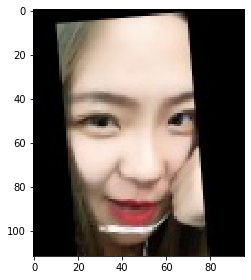

(112, 96, 3)


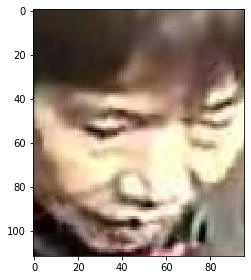

(112, 96, 3)


In [27]:
im1 = imread("/home/hooman/retrain_face_recognition/YY_3pt_aligned/inke_record_2019-05-30_21-52-40_1/inke_record_2019-05-30_21-52-40_1_00_0056.jpg")
im2 = imread("/home/hooman/retrain_face_recognition/20200120-20200122-4503/36040319600821002X/2a42f22f6fc74b549e93a0b7f0f00be1.jpg")

imshow(im1)
plt.show()
print(im1.shape)

imsave("/home/hooman/retrain_face_recognition/temp/im1.jpg", im1)

imshow(im2)
plt.show()
print(im2.shape)

imsave("/home/hooman/retrain_face_recognition/temp/im2.jpg", im2)